In [1]:
#@title Check if installation was successful

#from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Tue Dec 26 07:58:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               On  | 00000000:01:00.0  On |                  N/A |
| 49%   71C    P2             210W / 280W |  14723MiB / 24576MiB |     45%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
import gymnasium as gym
import cv2

env_name = 'PointMaze_UMaze-v3'
env = gym.make('PointMaze_UMaze-v3', render_mode='rgb_array', reward_type='dense')
env.reset()

n_frames = 120
height = 480
width = 480
frames = []
#import mujoco


# env.point_env.data.qpos[:] 

#joint_names = ['thigh_joint', 'leg_joint', 'foot_joint']
#joint_ranges = [env.model.joint(joint).range for joint in joint_names]


achieved_goal = np.array([0.944,  0.857])
for i in range(n_frames):
  #new_action = env.action_space
  # get random action Box(-1.0, 1.0, (2,), float32)
  #new_action = env.action_space.sample()
  #obs, reward, terminated, _, _ = env.step(new_action)
  #print(obs)
   # 0.944,  0.857,  0.093, -0.082
  
  #env.point_env.data.qpos[:] = [0.944,  0.857,  0.093, -0.082]
  env.point_env.data.qpos = achieved_goal
  env.point_env.data.qvel[:
  achieved_goal += np.array([0.01, 0.01])
  
  
  frame = env.render()
  # add reward to frame
  frame = np.array(frame)
  frame = cv2.putText(frame, f"reward: {reward}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  #print(obs)
  
  frames.append(frame)
media.show_video(frames, fps=30)



In [27]:
import minari
import pickle
import numpy as np
import collections
import minari

env_name = "pointmaze-umaze-v1"
actual_env_name = 'PointMaze_Umaze-v3'
dataset = minari.load_dataset("pointmaze-umaze-v1")
dataset = dataset._data.get_episodes(range(0,1000))

def _load_dataset_minari(env_name, dataset = None): # jensk

    trajectories = dataset
    states, traj_lens, returns = [], [], []
    if 'pointmaze' in env_name :
        # re-label observation. (achieved_goal, desired_goal) -> observation
        print("re-label observation. (achieved_goal, desired_goal) -> observation")
        for path in trajectories :
            achieved_goal = path['observations']['achieved_goal'][1:]
            desired_goal = path['observations']['desired_goal'][1:]
            observation = np.concatenate([achieved_goal, desired_goal], axis=1)
            path['observations'] = observation

    for path in trajectories:
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
        # for pointmaze
    traj_lens, returns = np.array(traj_lens), np.array(returns)
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print(f"Average length: {np.mean(traj_lens):.2f}, std: {np.std(traj_lens):.2f}")
    print(f"Max length: {np.max(traj_lens):.2f}, min: {np.min(traj_lens):.2f}")
    print("=" * 50)

    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    trajectories = [trajectories[ii] for ii in sorted_inds]
    return trajectories, state_mean, state_std

def _load_dataset_01(env_name) :

    offline_trajs, state_mean, state_std = _load_dataset_minari(env_name, dataset)
    # create ['K'] length trajectories with initial state and final state
    offline_trajs_01 = []
    for traj in offline_trajs:
        traj_len = len(traj["observations"])
        # divide the trajectory into K length. get index of K length
        if traj_len < variant["K"] :
            continue 
        index = np.linspace(0, traj_len - 1, variant["K"]).astype(int)
        #print(f"traj len: {traj_len}, index : {index}")
        # get the state and action of the index
        # get the initial action and final action
        for key in traj.keys() :
            if key in ['id', 'total_timesteps', 'seed' ] :
                continue
            traj[key] = traj[key][index]
        offline_trajs_01.append(traj)
    print(f"offline_trajs_01 : {len(offline_trajs_01)}")
    return offline_trajs_01, state_mean, state_std
    
variant = {}
variant['K'] = 20

data, state_mean, state_std = _load_dataset_01('pointmaze-umaze-v1')

re-label observation. (achieved_goal, desired_goal) -> observation
Starting new experiment: pointmaze-umaze-v1
1000 trajectories, 73537 timesteps found
Average return: 1.00, std: 0.00
Max return: 1.00, min: 1.00
Average length: 73.54, std: 43.50
Max length: 183.00, min: 1.00
offline_trajs_01 : 885


885


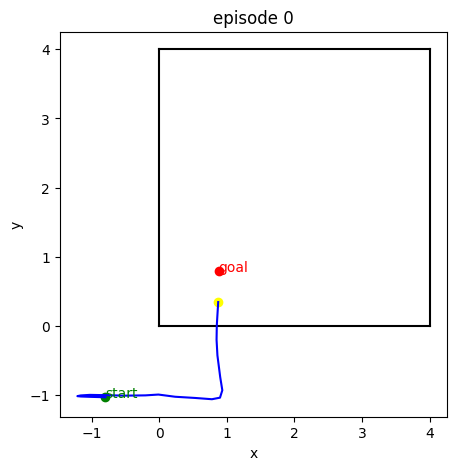

episode done at 0


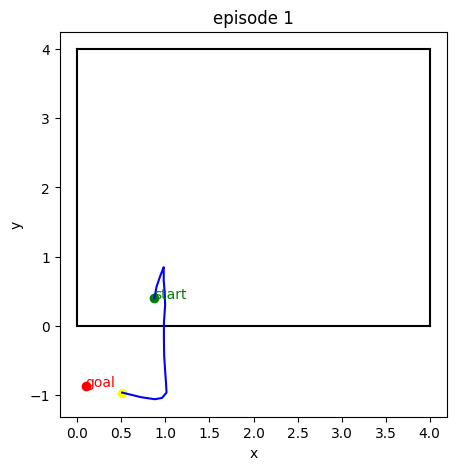

episode done at 1


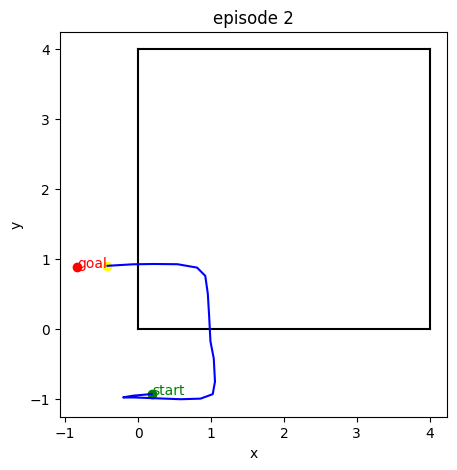

episode done at 2


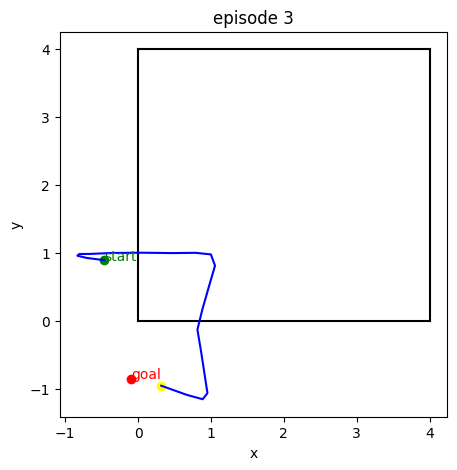

episode done at 3


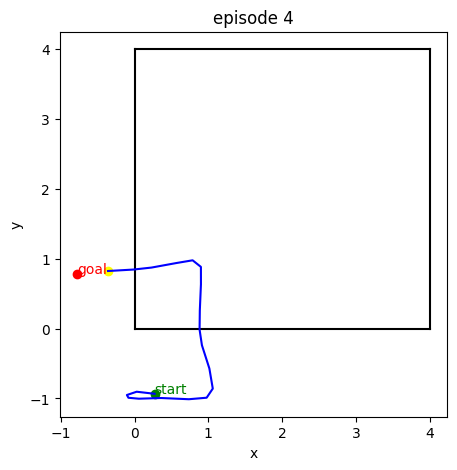

episode done at 4


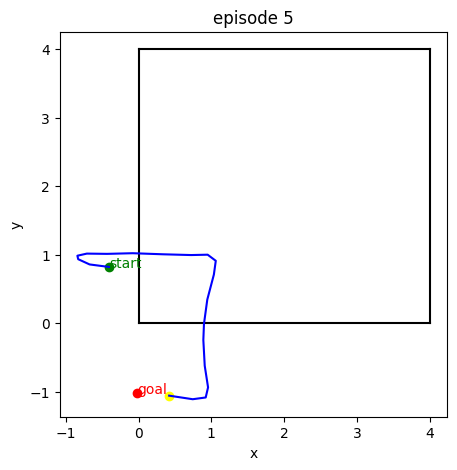

episode done at 5


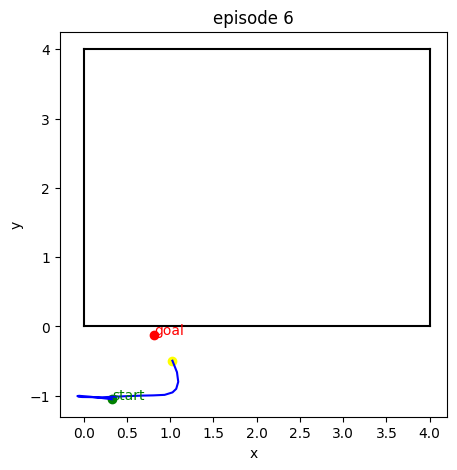

episode done at 6


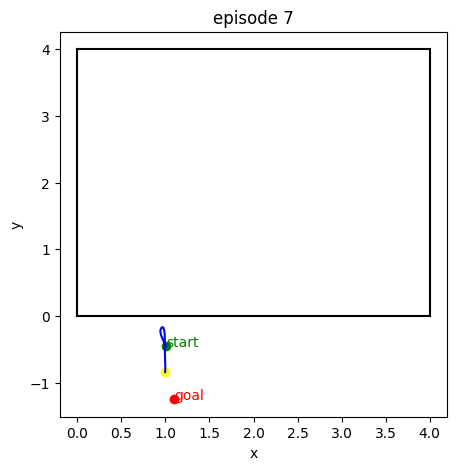

episode done at 7


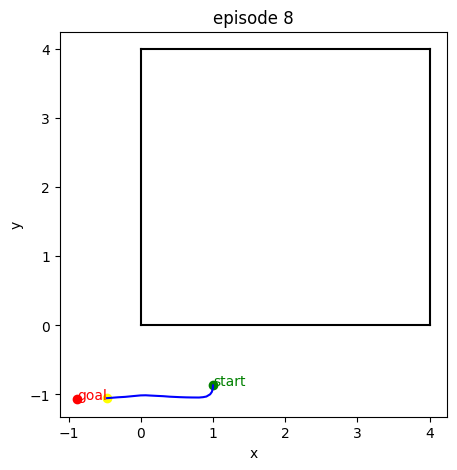

episode done at 8


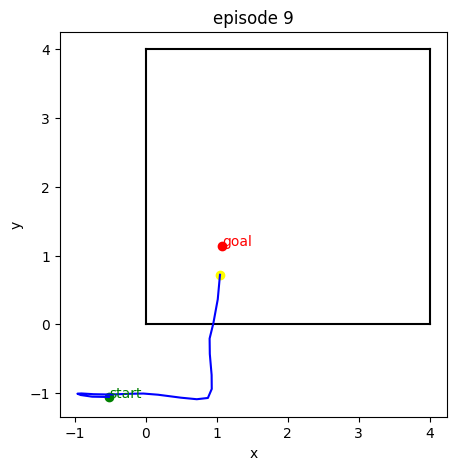

episode done at 9


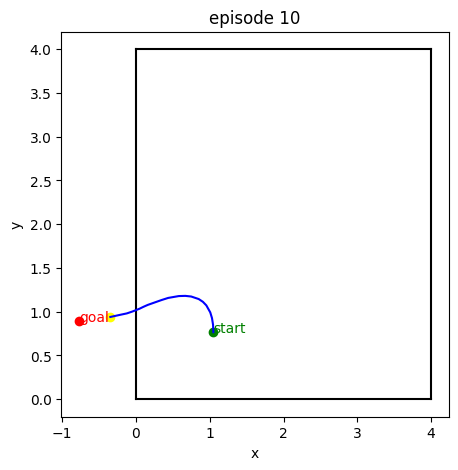

episode done at 10


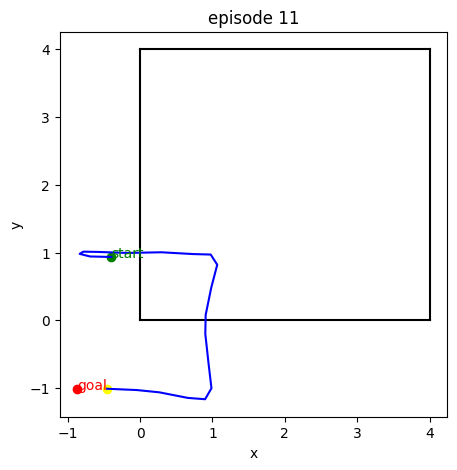

episode done at 11


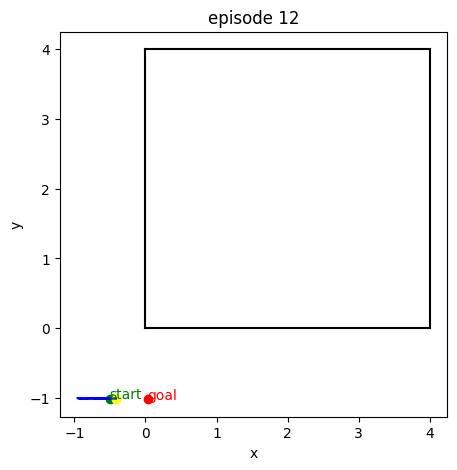

episode done at 12


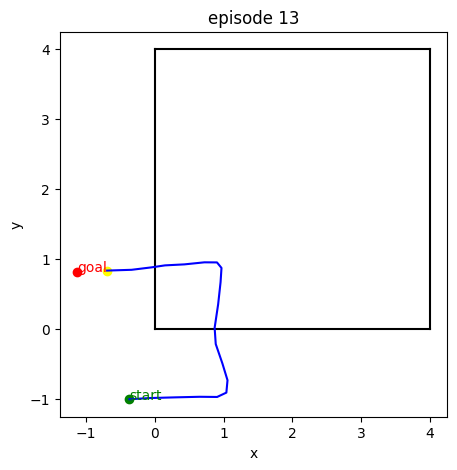

episode done at 13


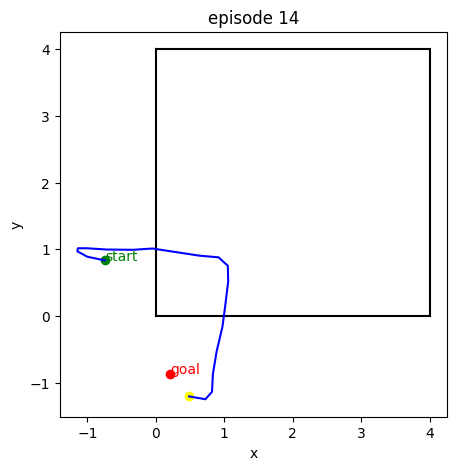

episode done at 14


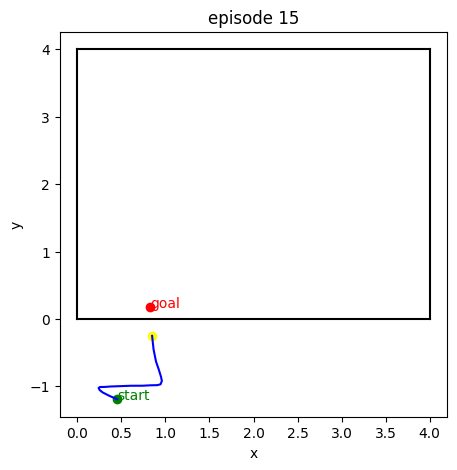

episode done at 15


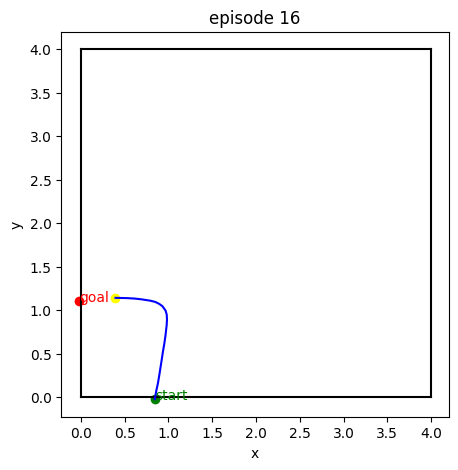

episode done at 16


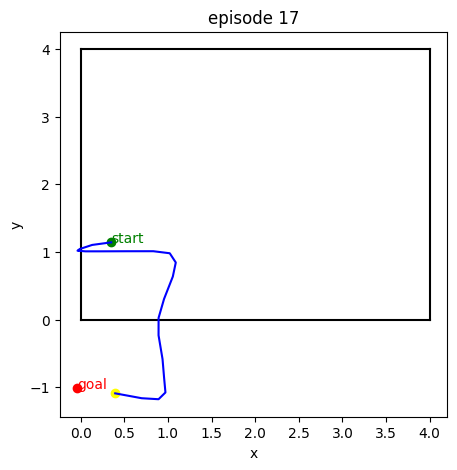

episode done at 17


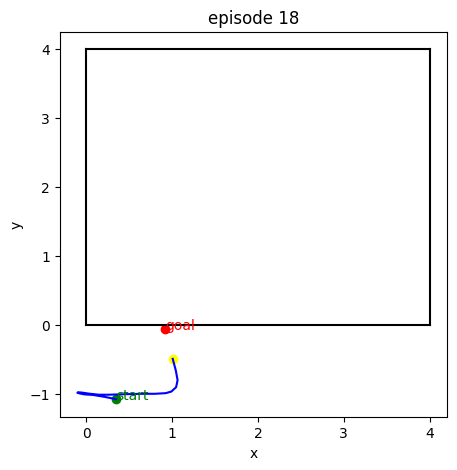

episode done at 18


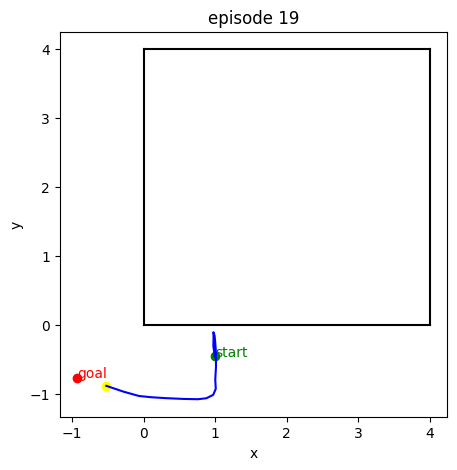

episode done at 19


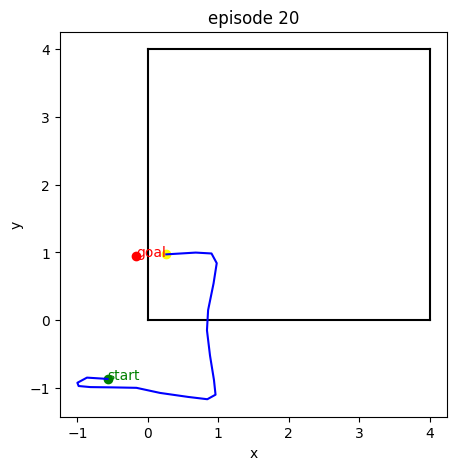

episode done at 20


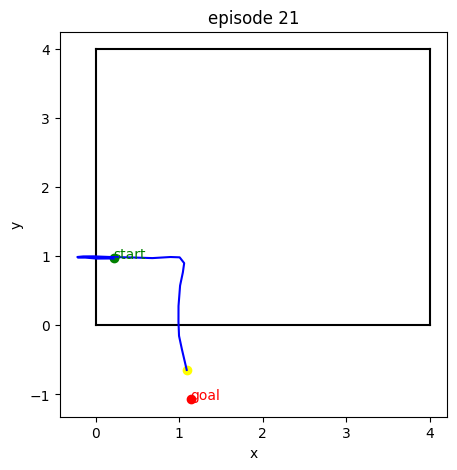

episode done at 21


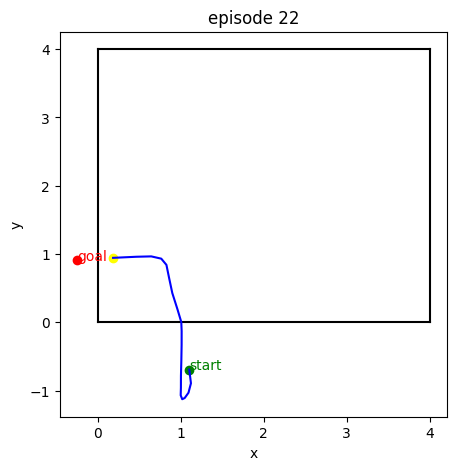

episode done at 22


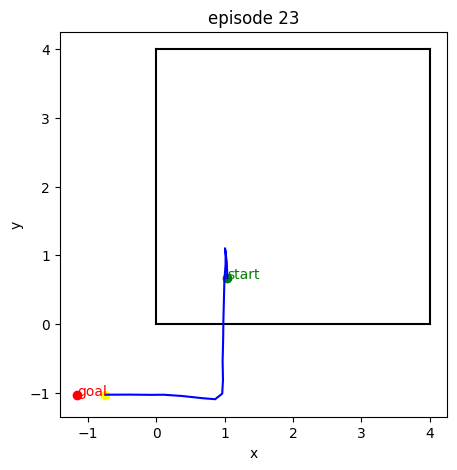

episode done at 23


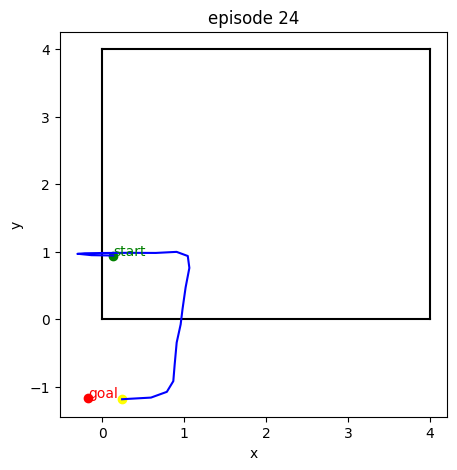

episode done at 24


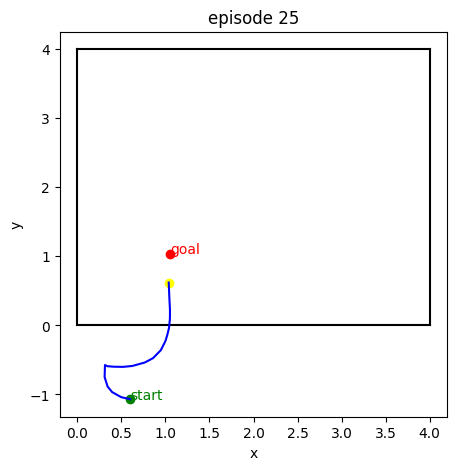

episode done at 25


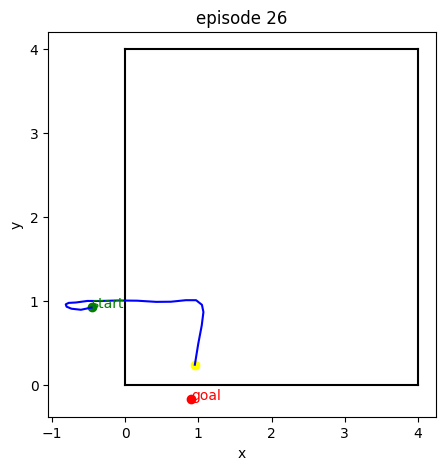

episode done at 26


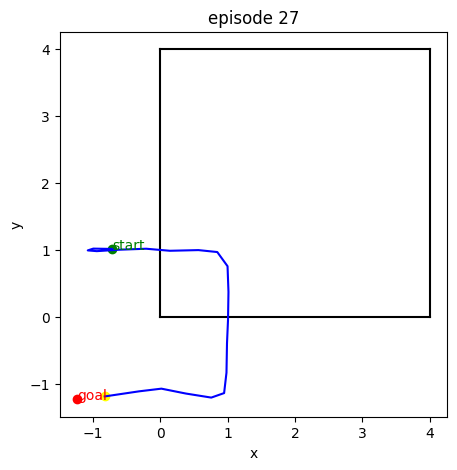

episode done at 27


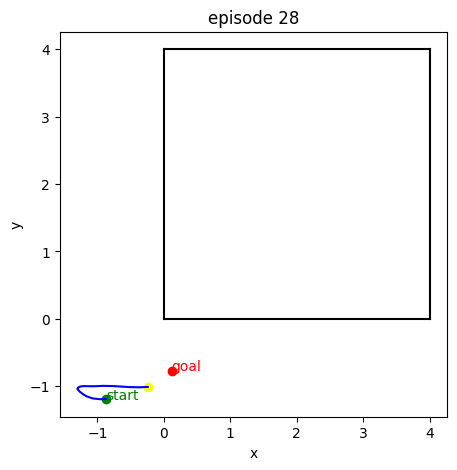

episode done at 28


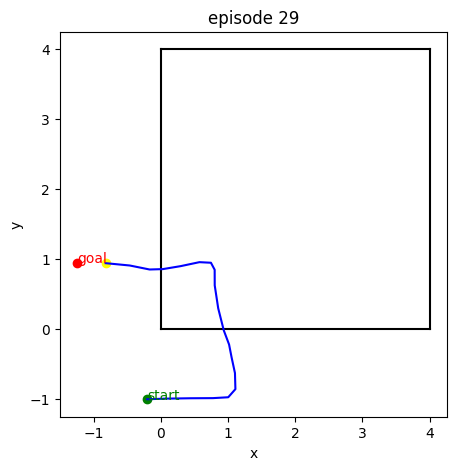

episode done at 29


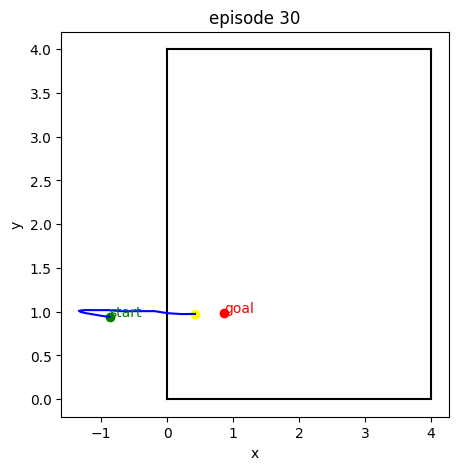

episode done at 30


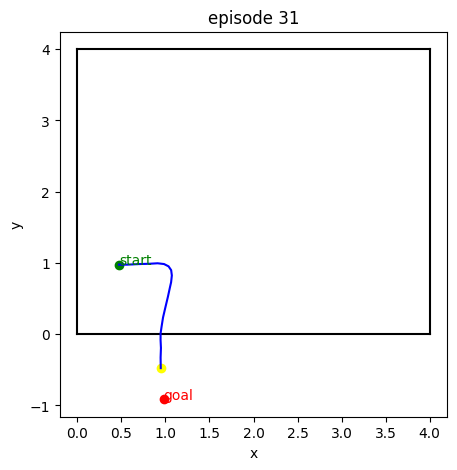

episode done at 31


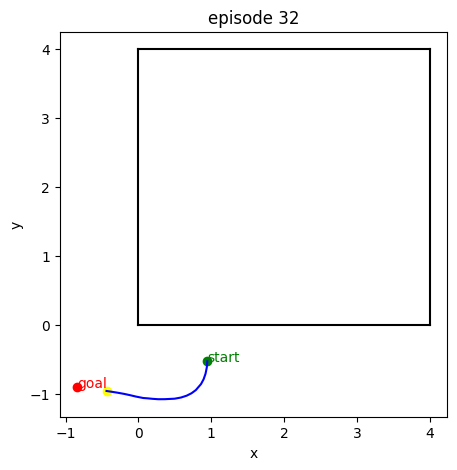

episode done at 32


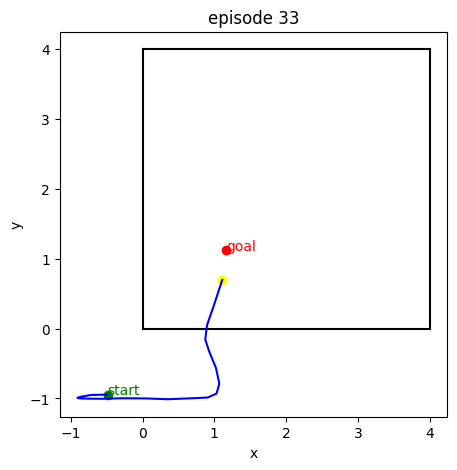

episode done at 33


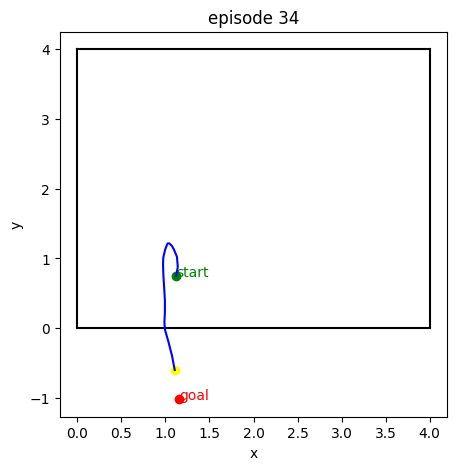

episode done at 34


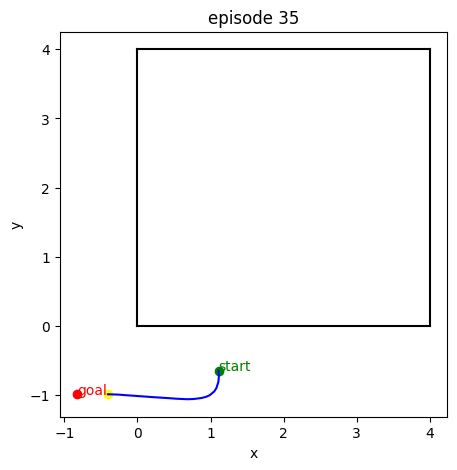

episode done at 35


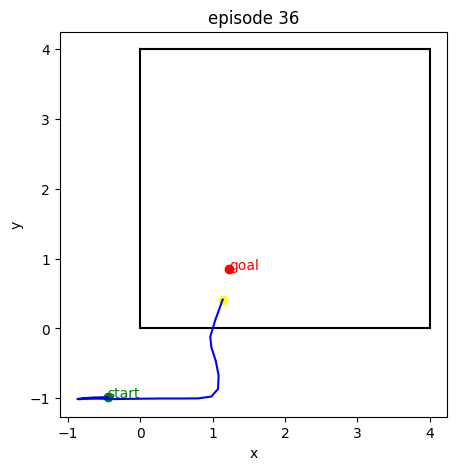

episode done at 36


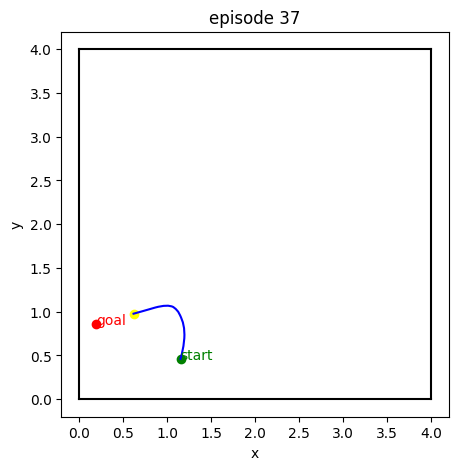

episode done at 37


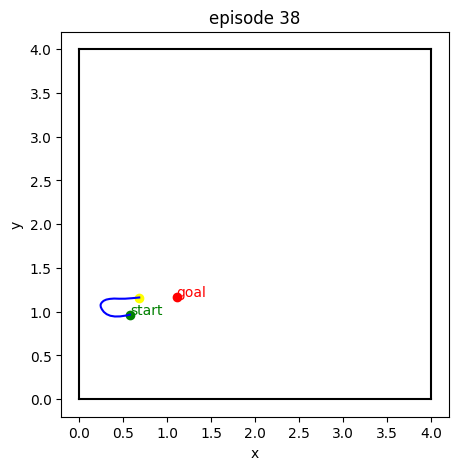

episode done at 38


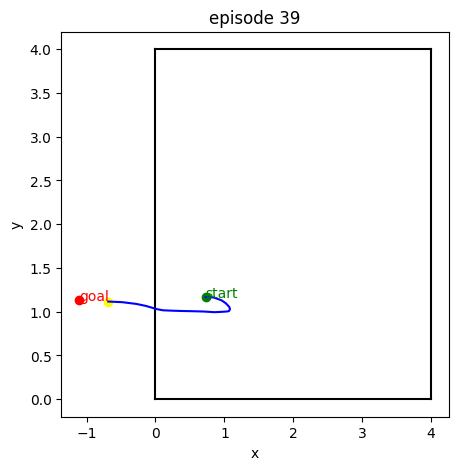

episode done at 39


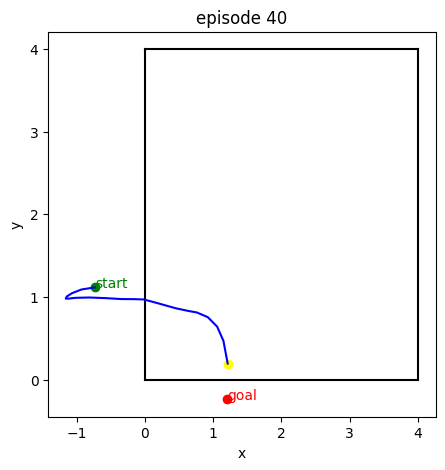

episode done at 40


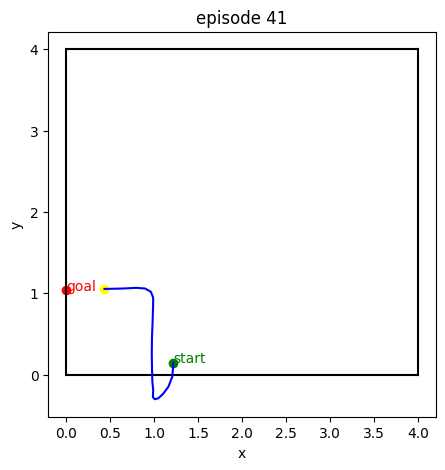

episode done at 41


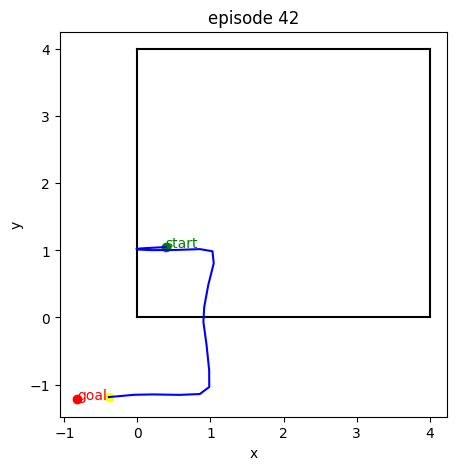

episode done at 42


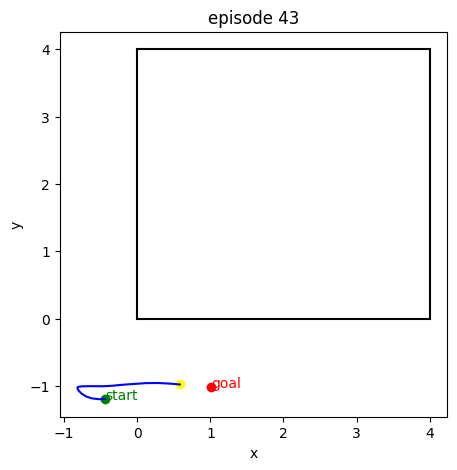

episode done at 43


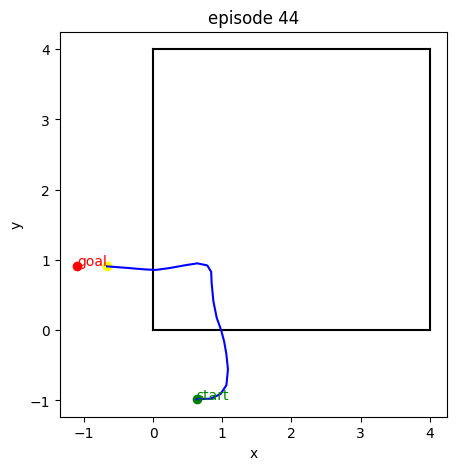

episode done at 44


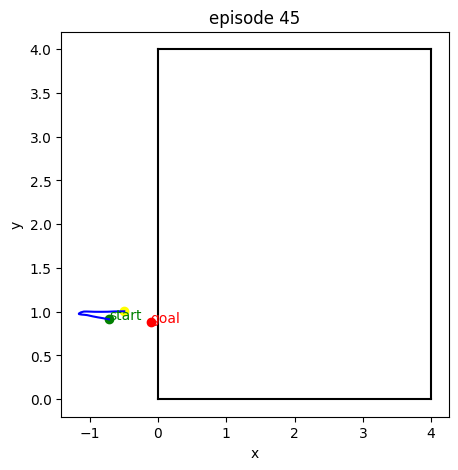

episode done at 45


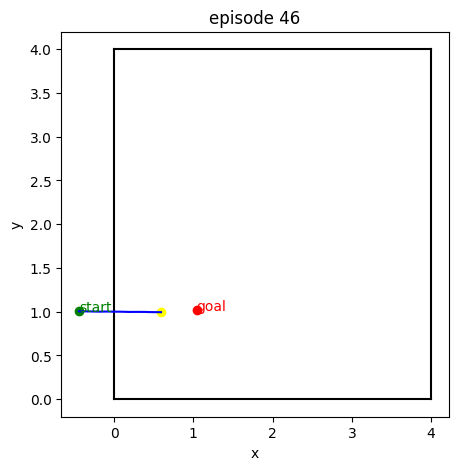

episode done at 46


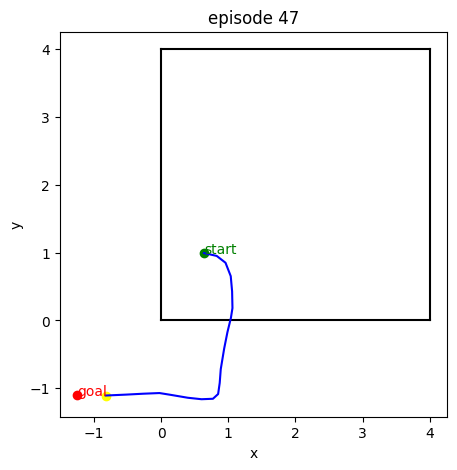

episode done at 47


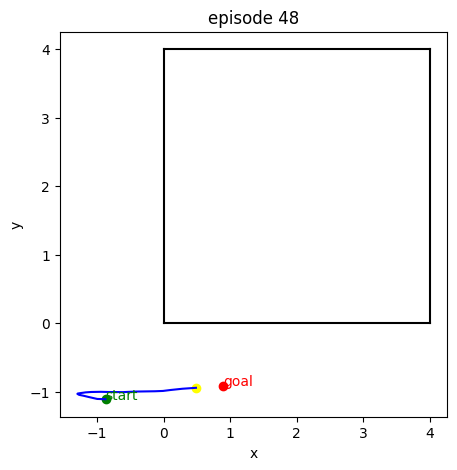

episode done at 48


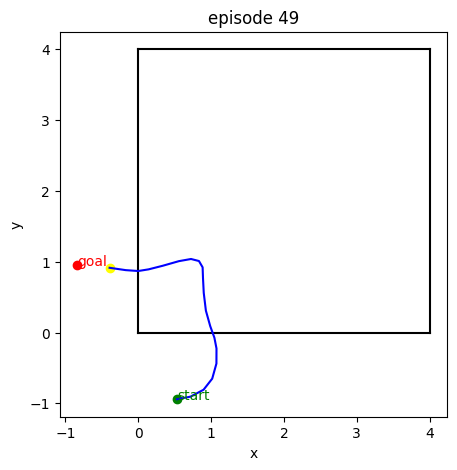

episode done at 49


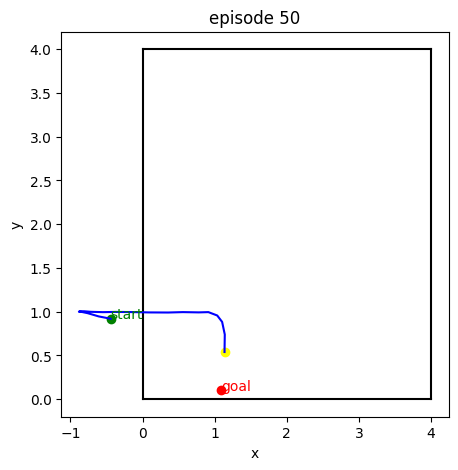

episode done at 50


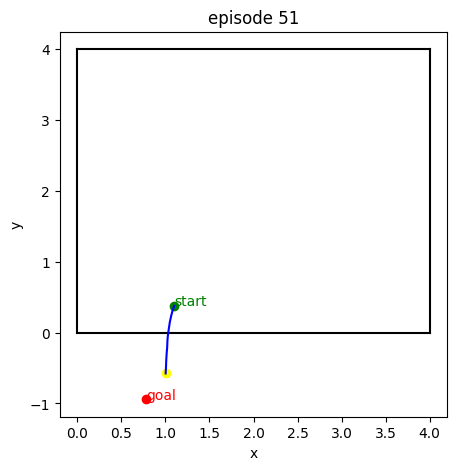

episode done at 51


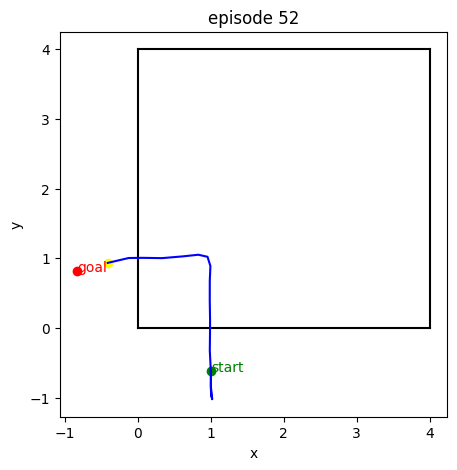

episode done at 52


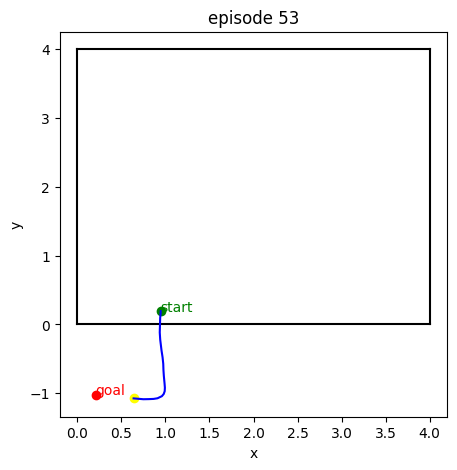

episode done at 53


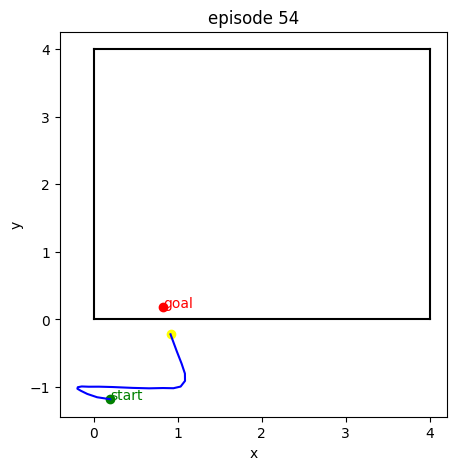

episode done at 54


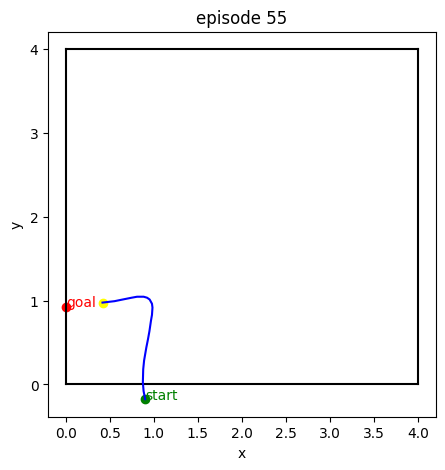

episode done at 55


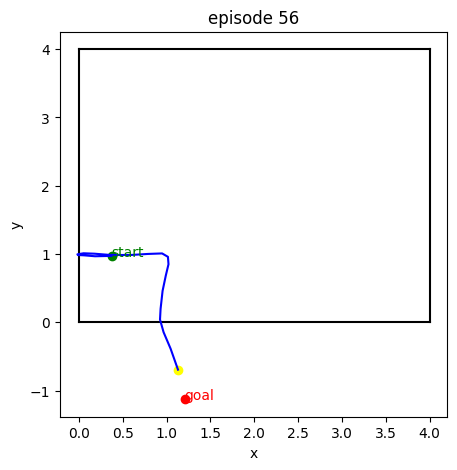

episode done at 56


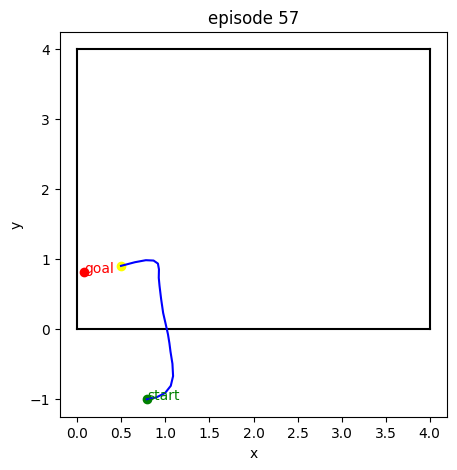

episode done at 57


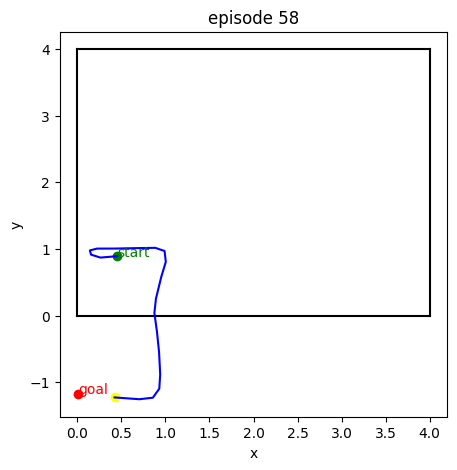

episode done at 58


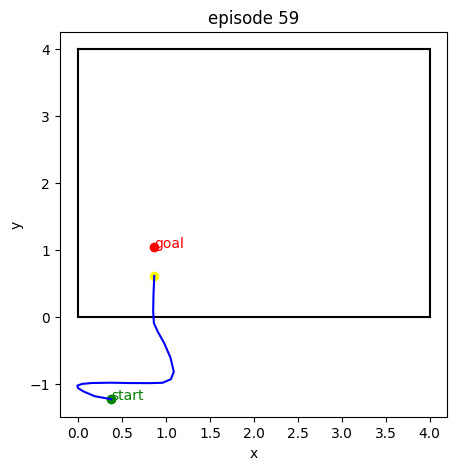

episode done at 59


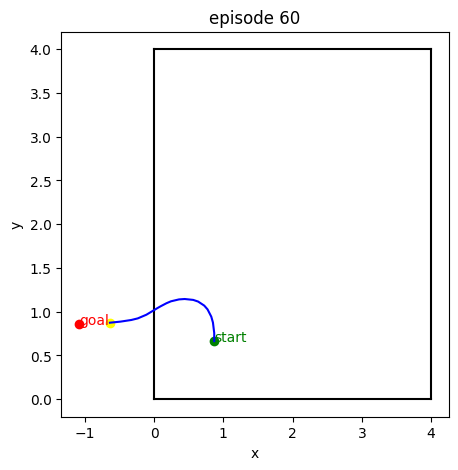

episode done at 60


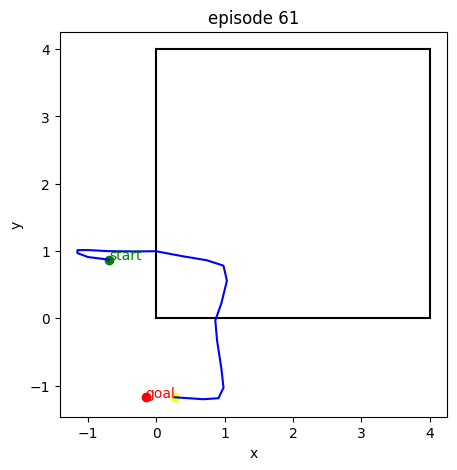

episode done at 61


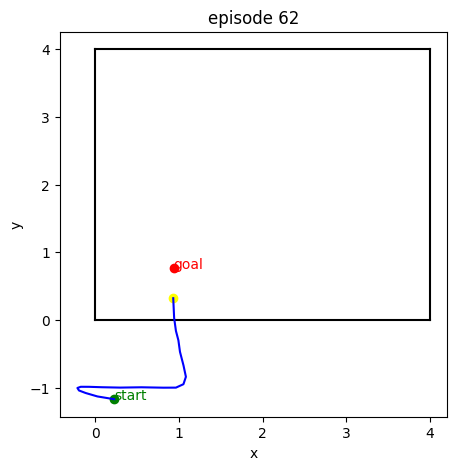

episode done at 62


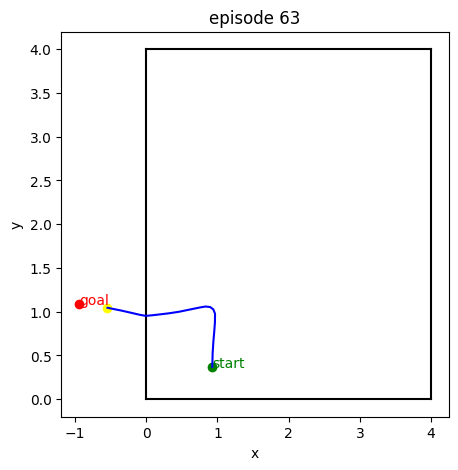

episode done at 63


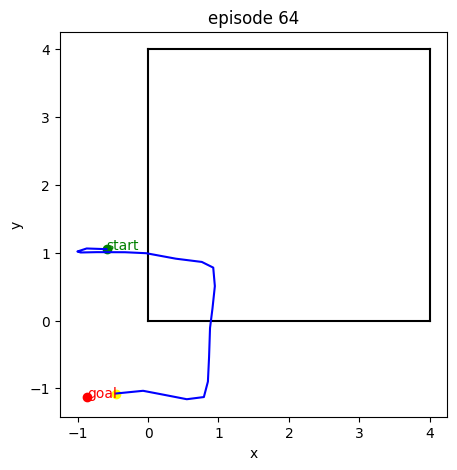

episode done at 64


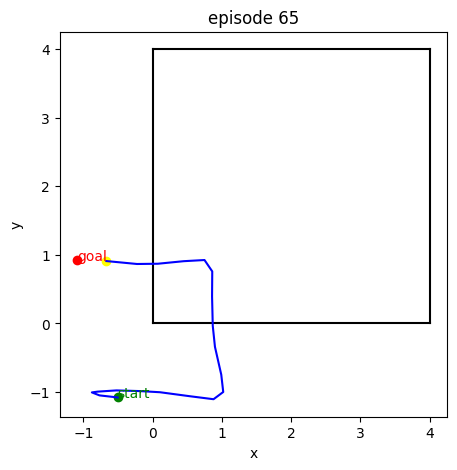

episode done at 65


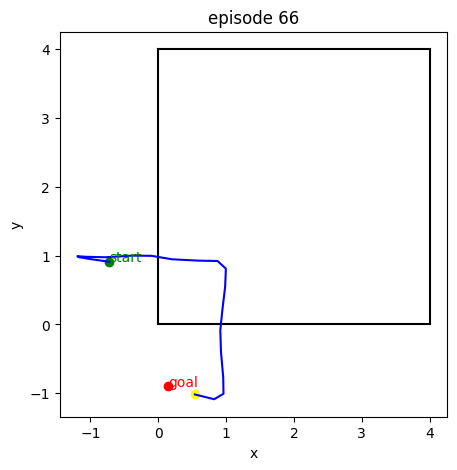

episode done at 66


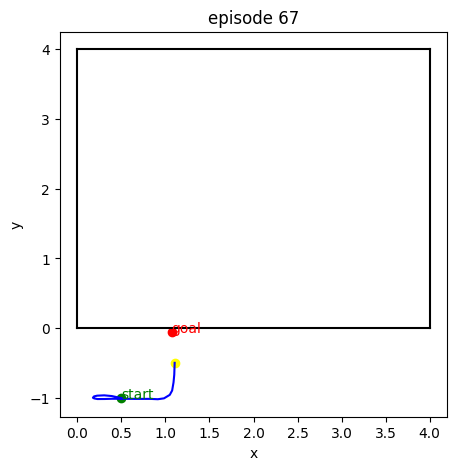

episode done at 67


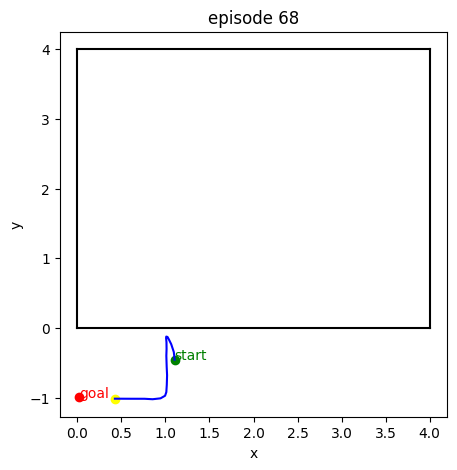

episode done at 68


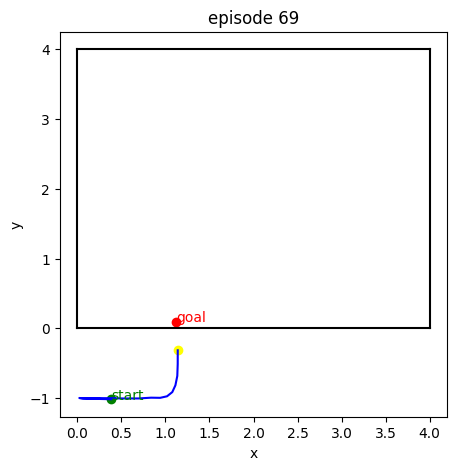

episode done at 69


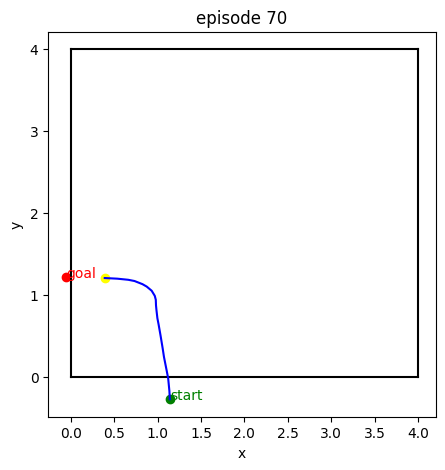

episode done at 70


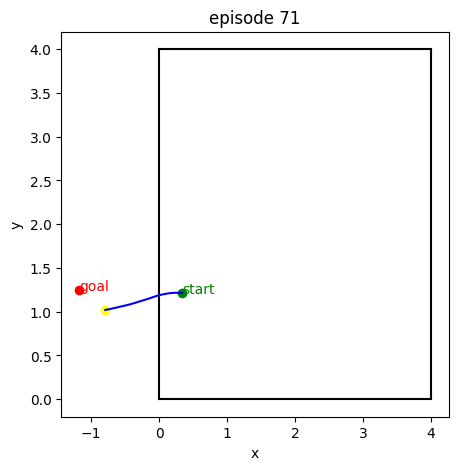

episode done at 71


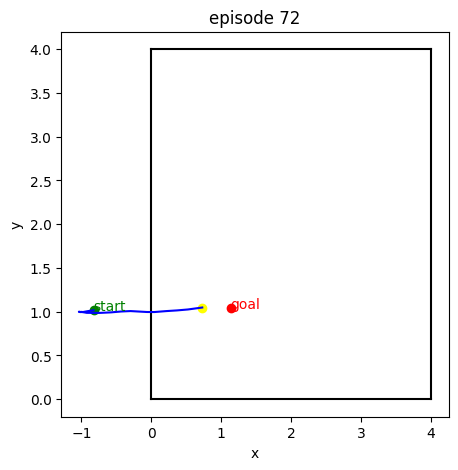

episode done at 72


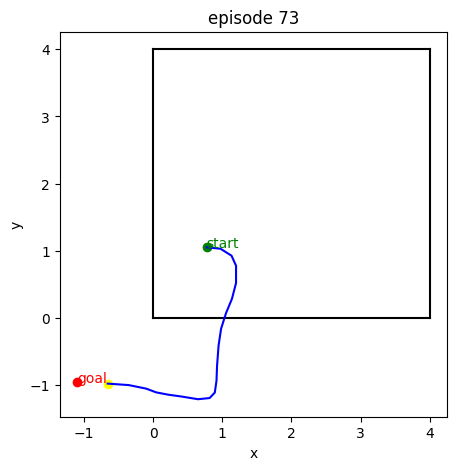

episode done at 73


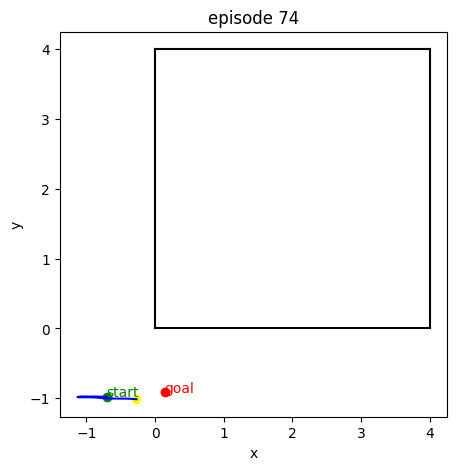

episode done at 74


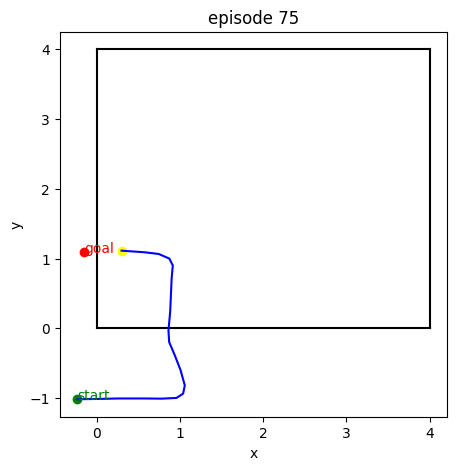

episode done at 75


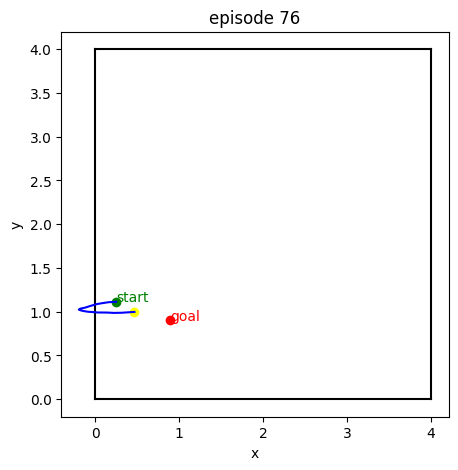

episode done at 76


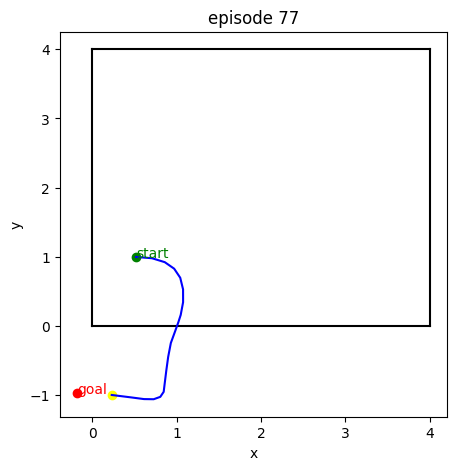

episode done at 77


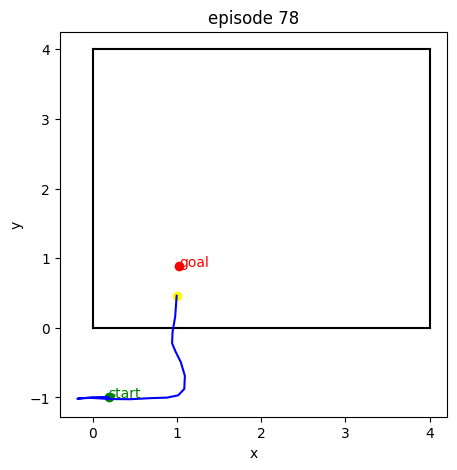

episode done at 78


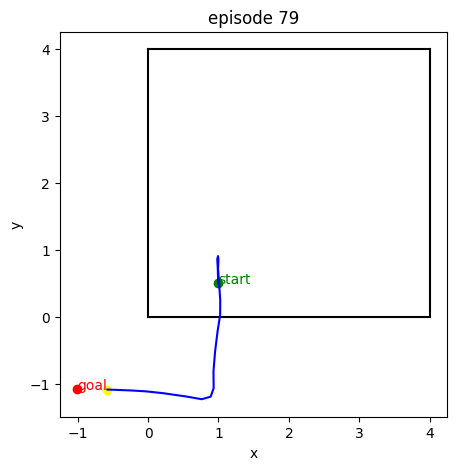

episode done at 79


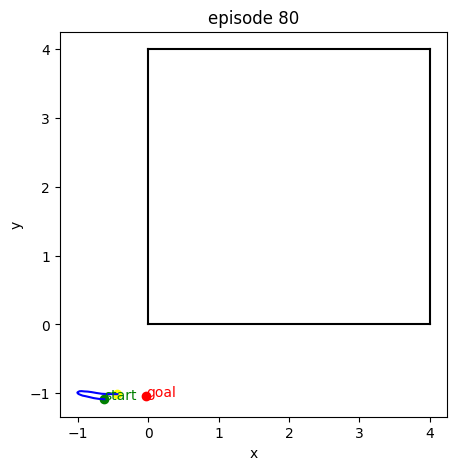

episode done at 80


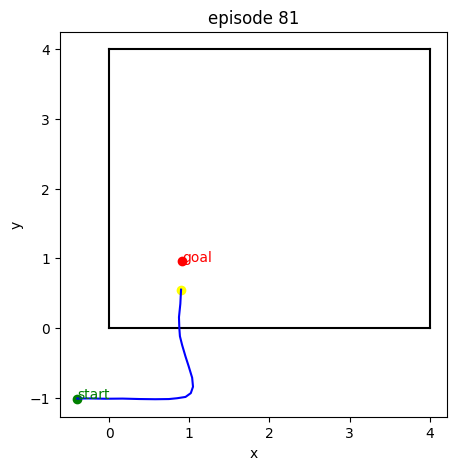

episode done at 81


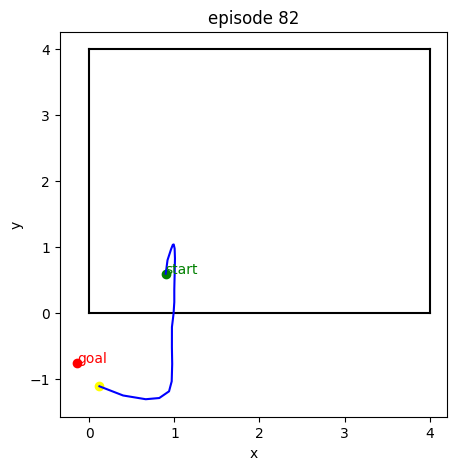

episode done at 82


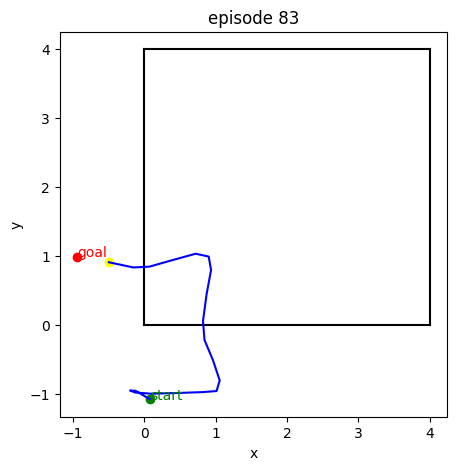

episode done at 83


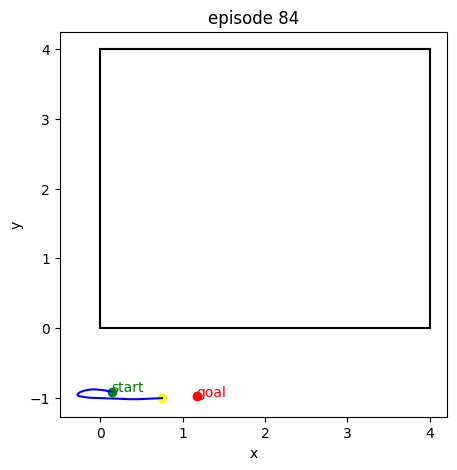

episode done at 84


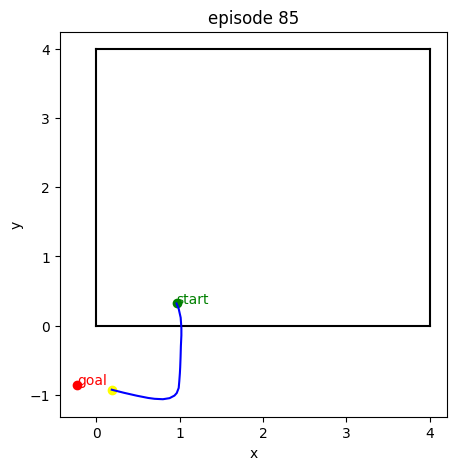

episode done at 85


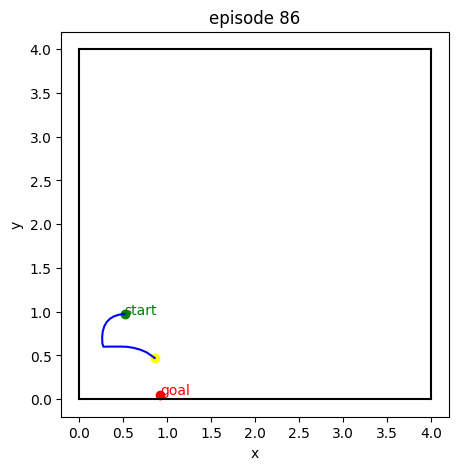

episode done at 86


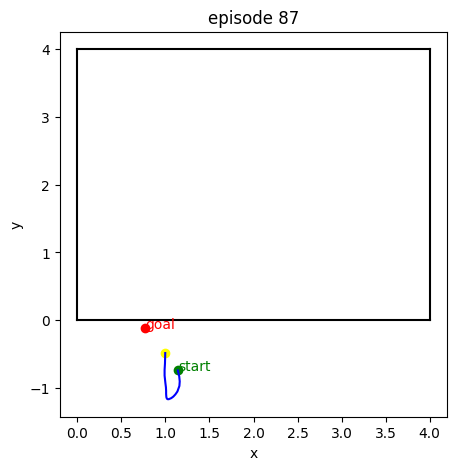

episode done at 87


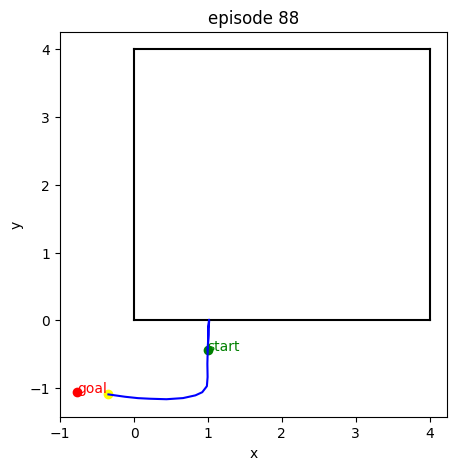

episode done at 88


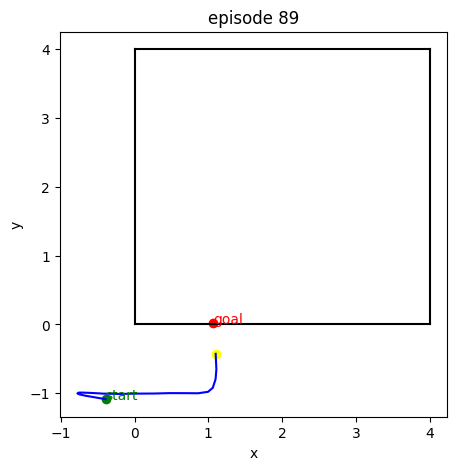

episode done at 89


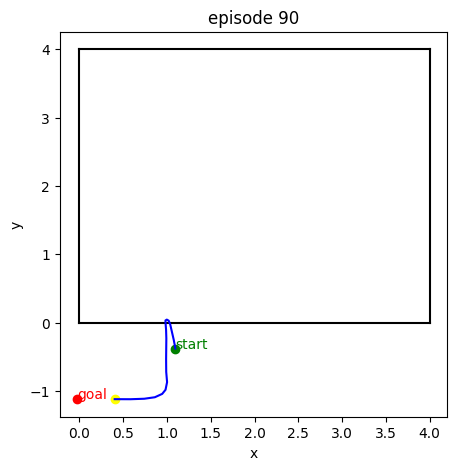

episode done at 90


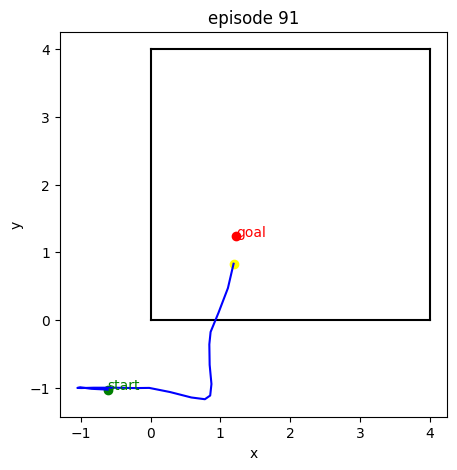

episode done at 91


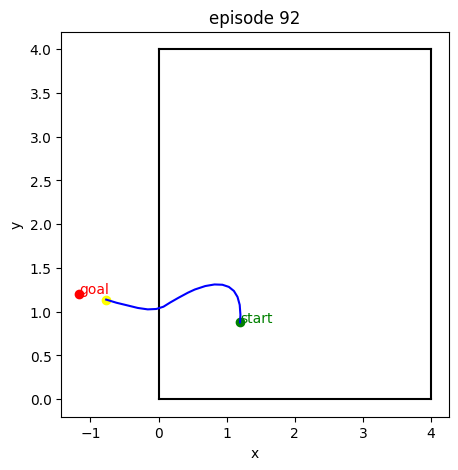

episode done at 92


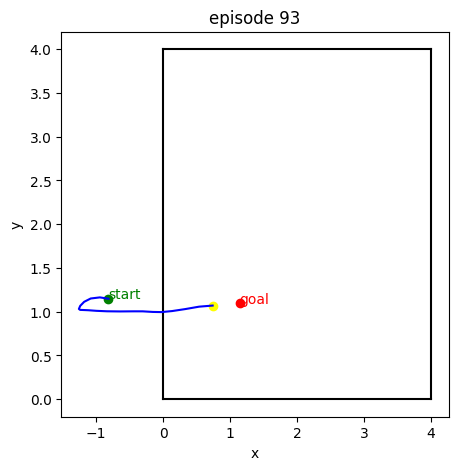

episode done at 93


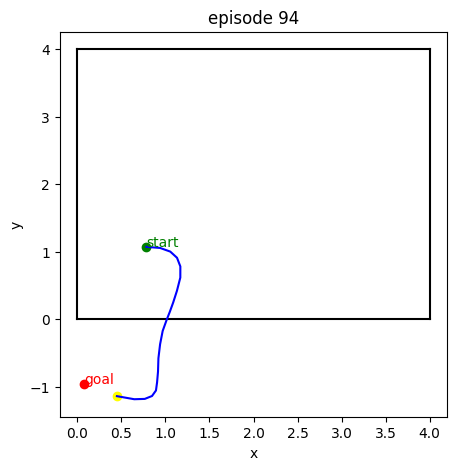

episode done at 94


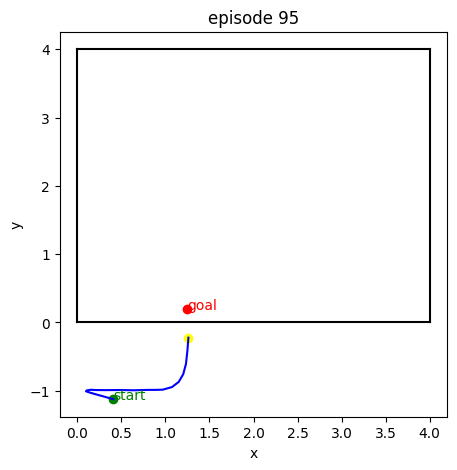

episode done at 95


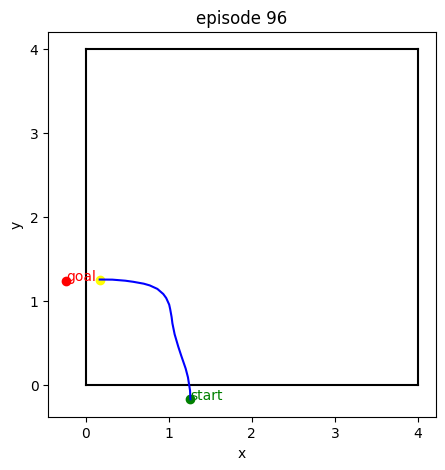

episode done at 96


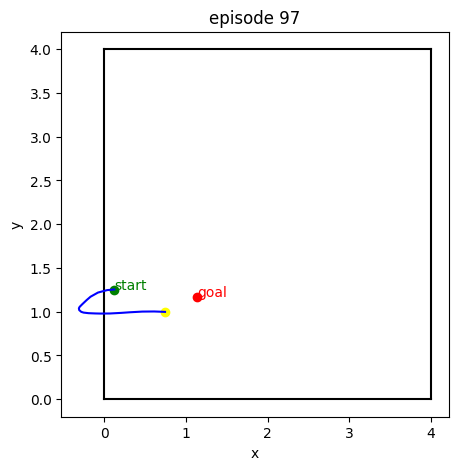

episode done at 97


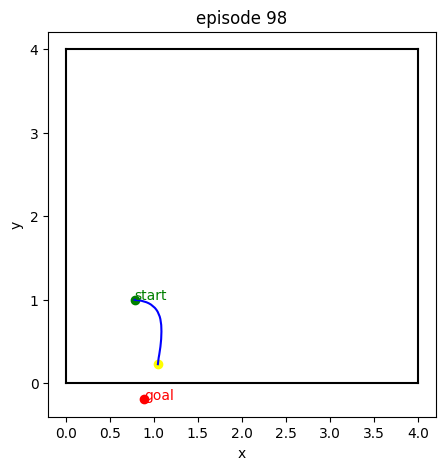

episode done at 98


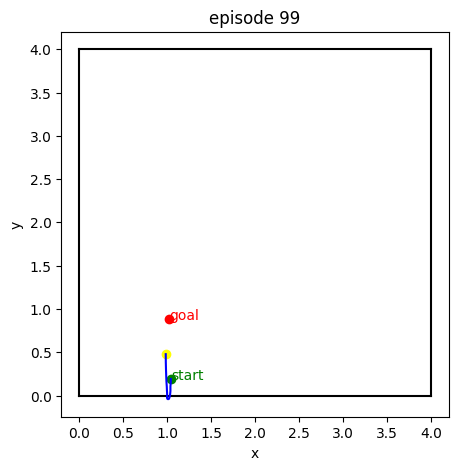

episode done at 99


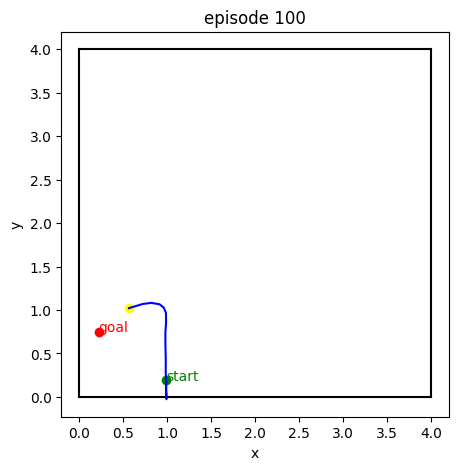

episode done at 100


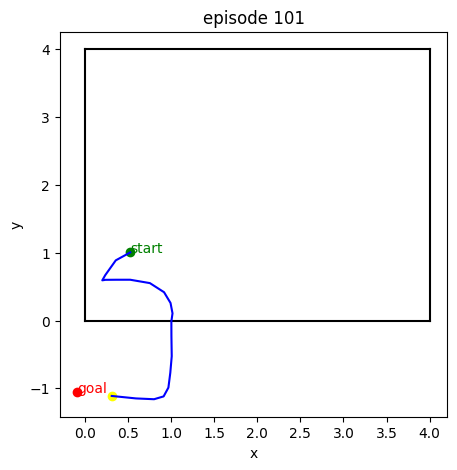

episode done at 101


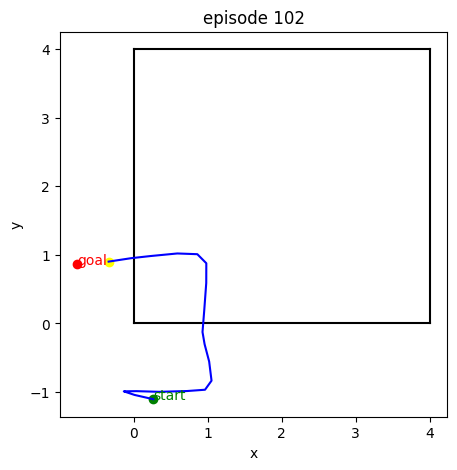

episode done at 102


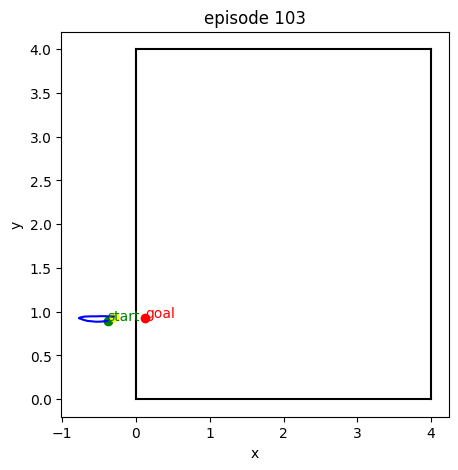

episode done at 103


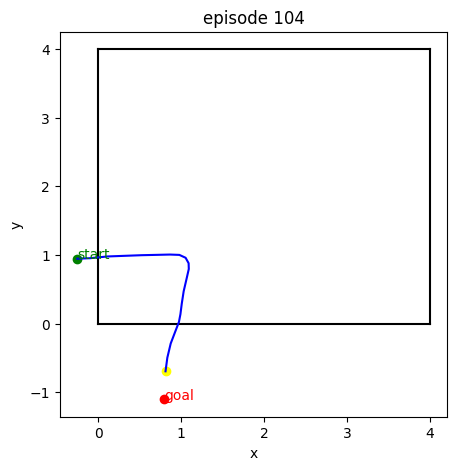

episode done at 104


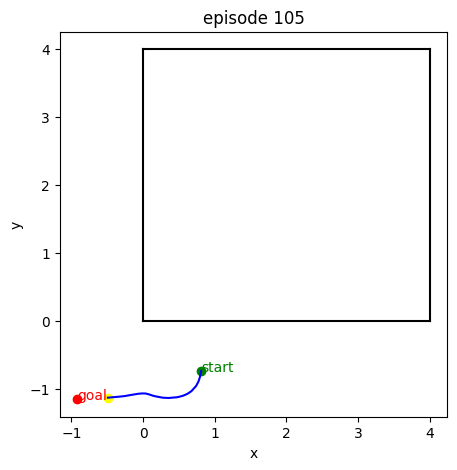

episode done at 105


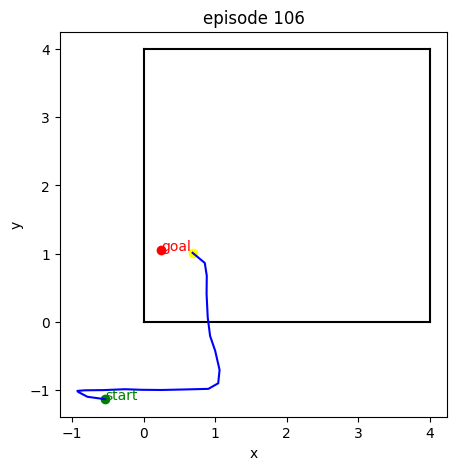

episode done at 106


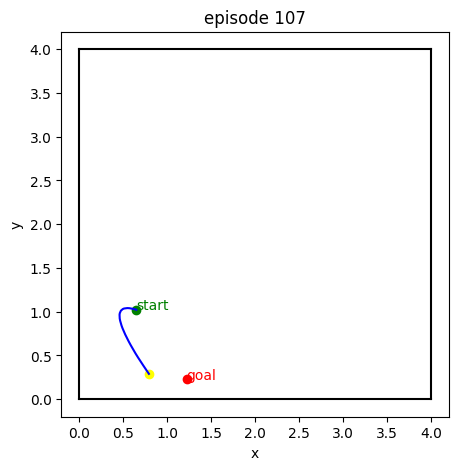

episode done at 107


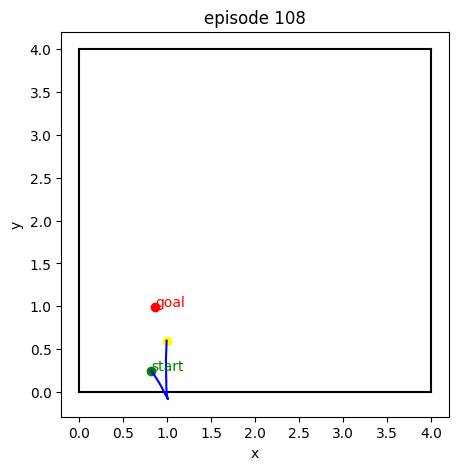

episode done at 108


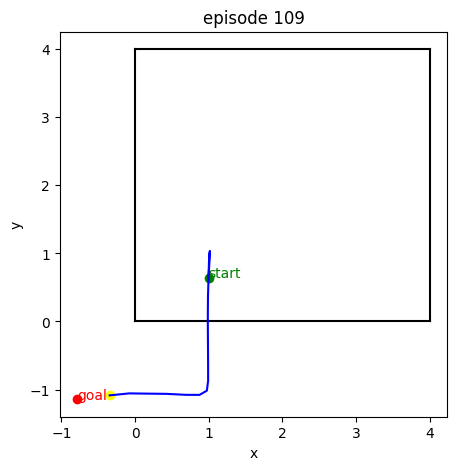

episode done at 109


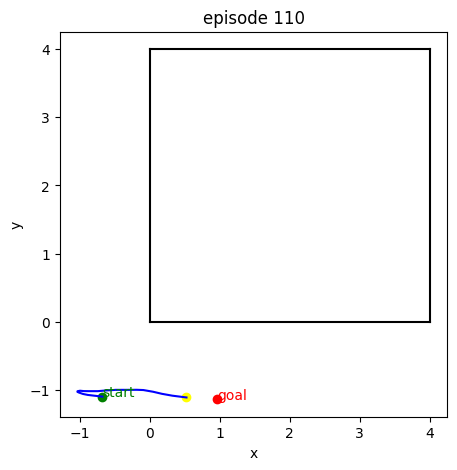

episode done at 110


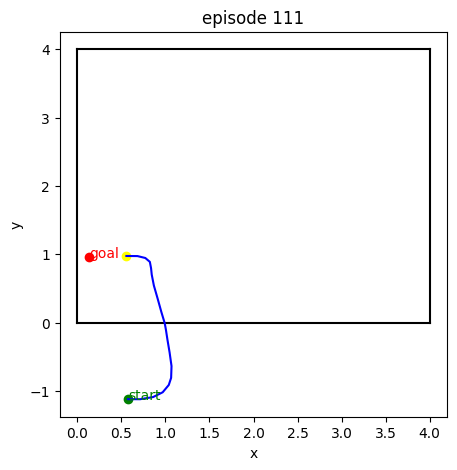

episode done at 111


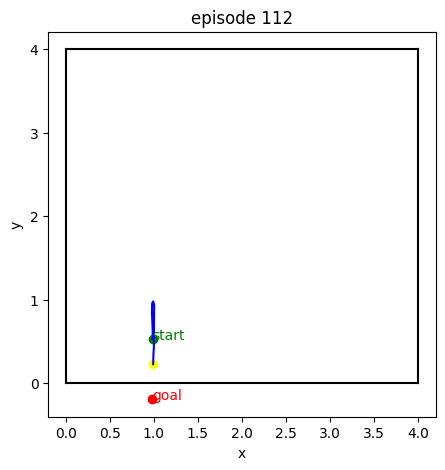

episode done at 112


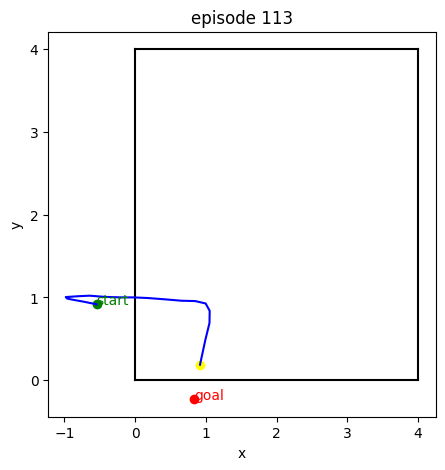

episode done at 113


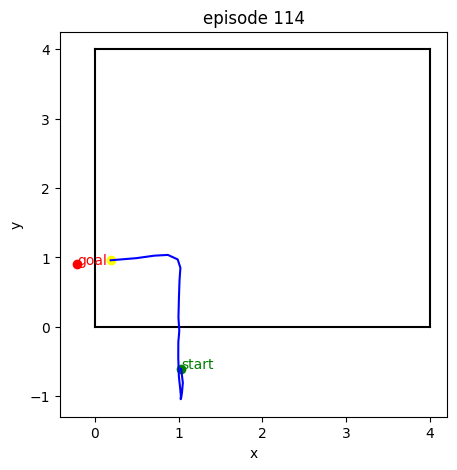

episode done at 114


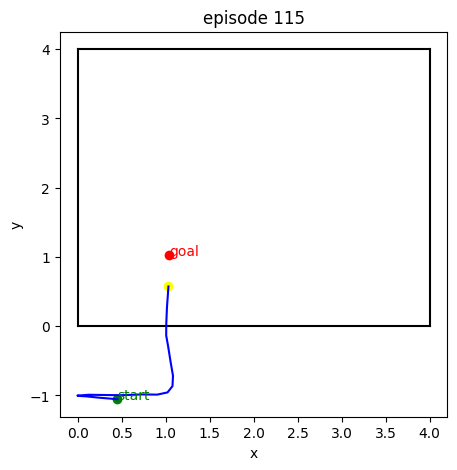

episode done at 115


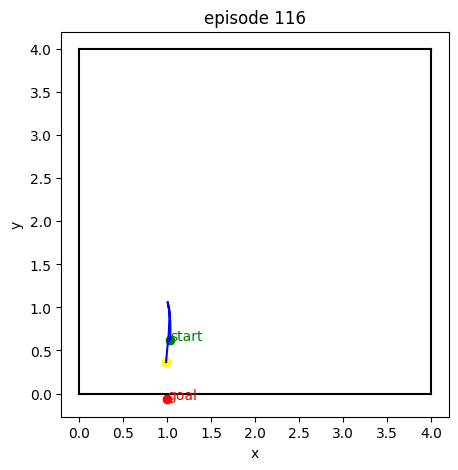

episode done at 116


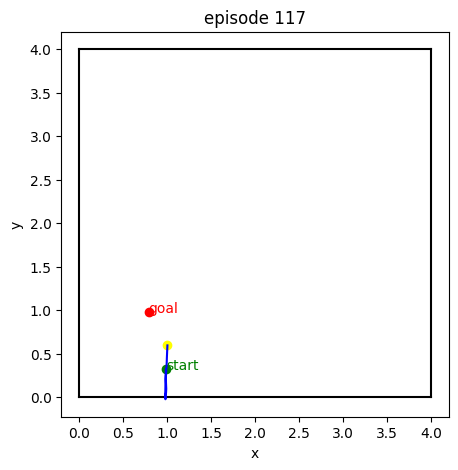

episode done at 117


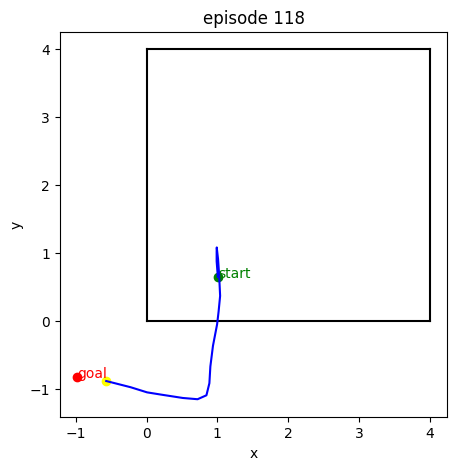

episode done at 118


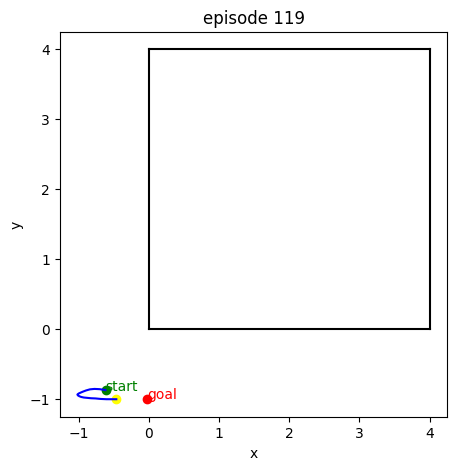

episode done at 119


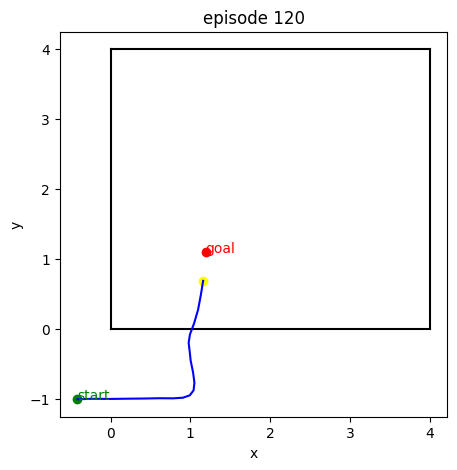

episode done at 120


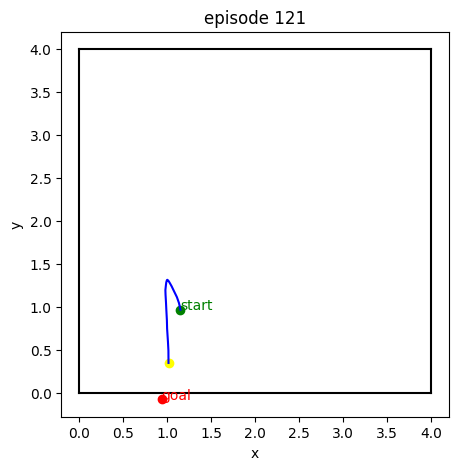

episode done at 121


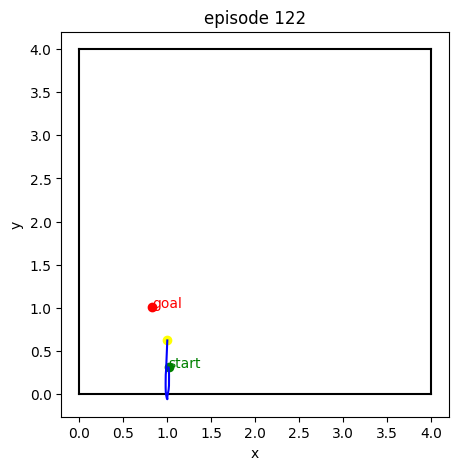

episode done at 122


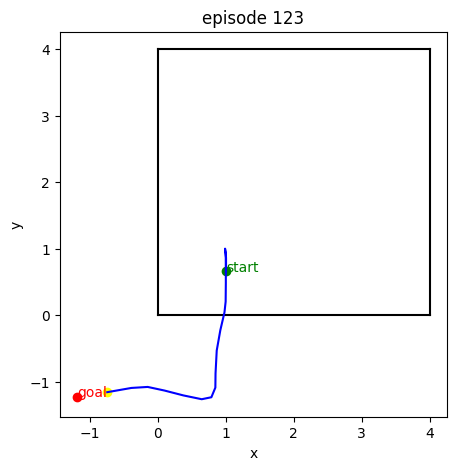

episode done at 123


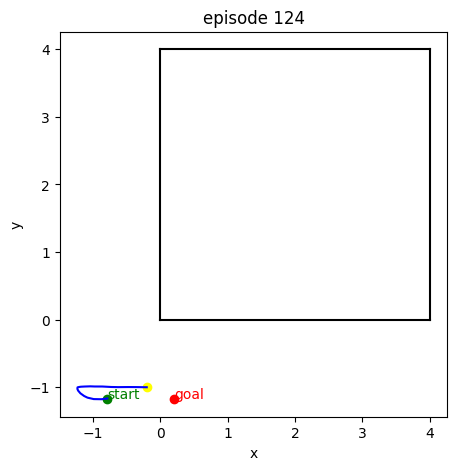

episode done at 124


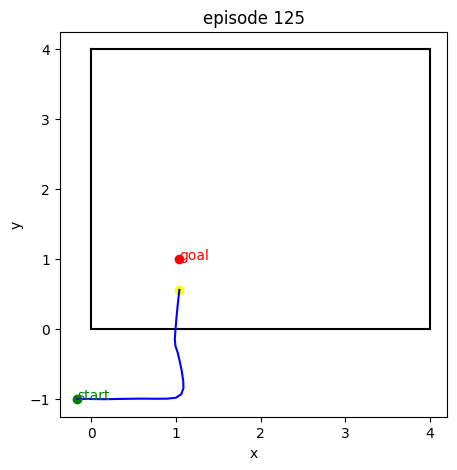

episode done at 125


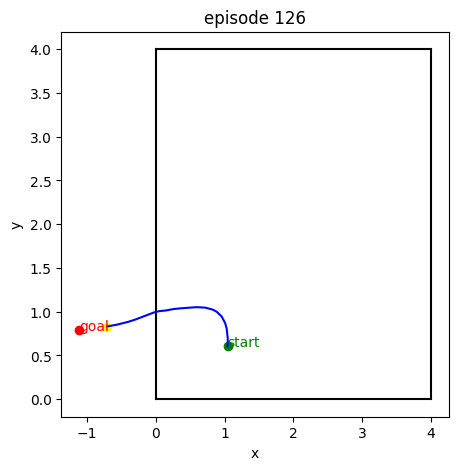

episode done at 126


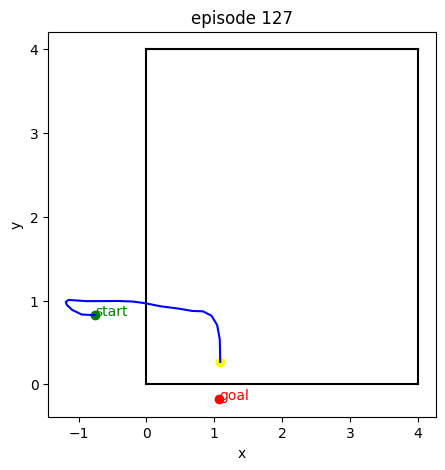

episode done at 127


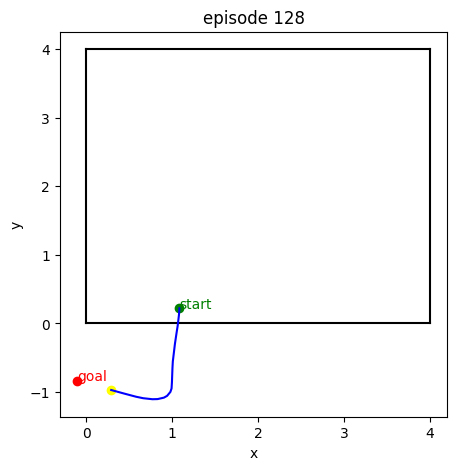

episode done at 128


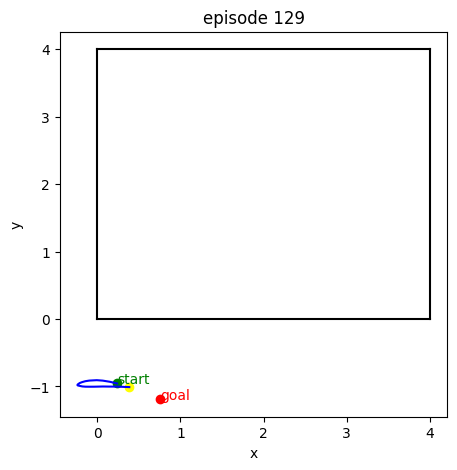

episode done at 129


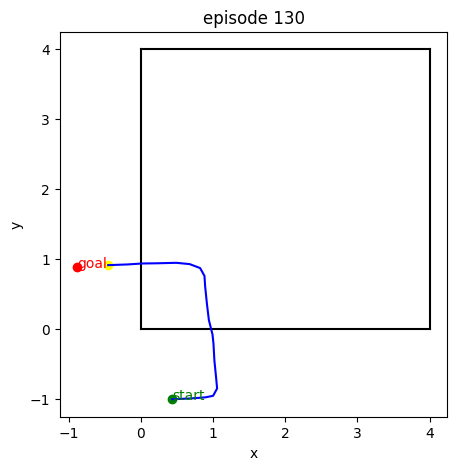

episode done at 130


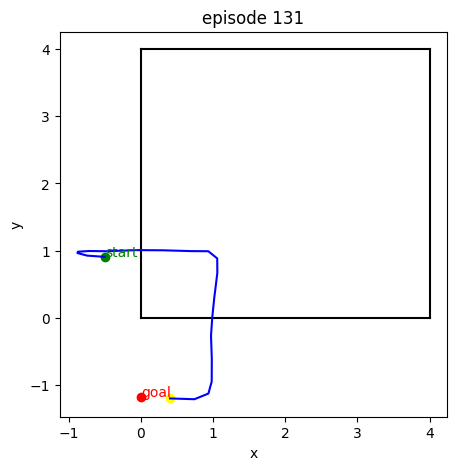

episode done at 131


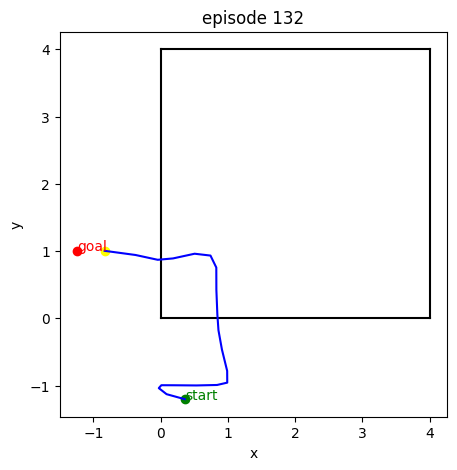

episode done at 132


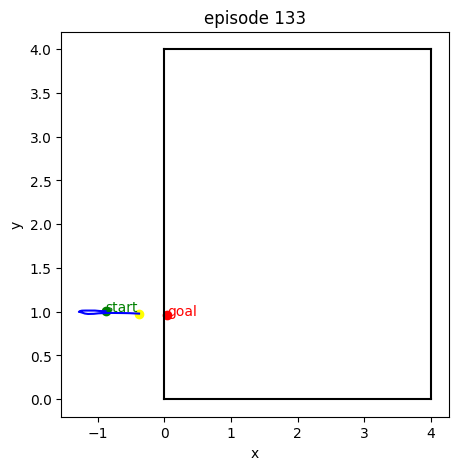

episode done at 133


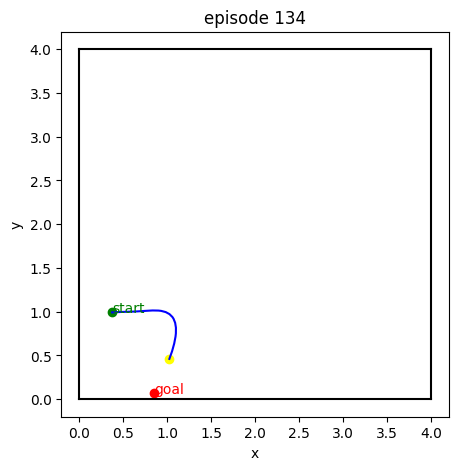

episode done at 134


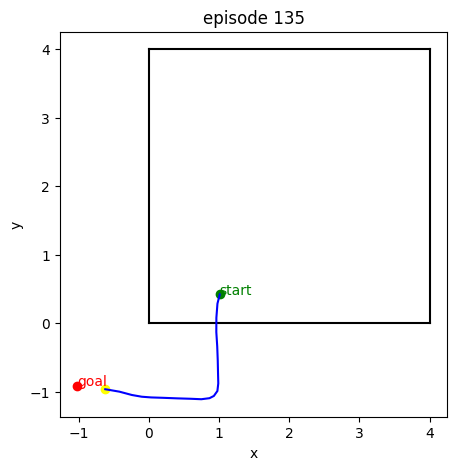

episode done at 135


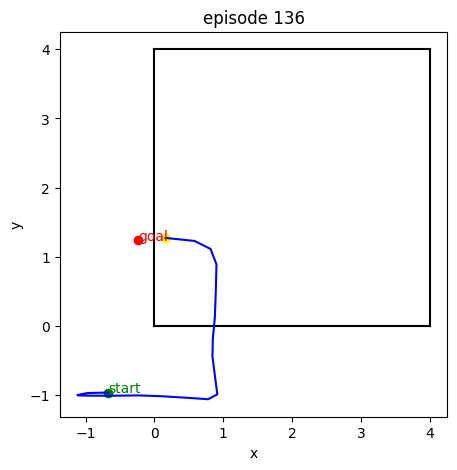

episode done at 136


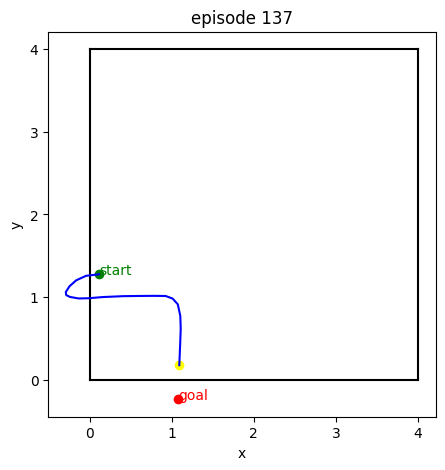

episode done at 137


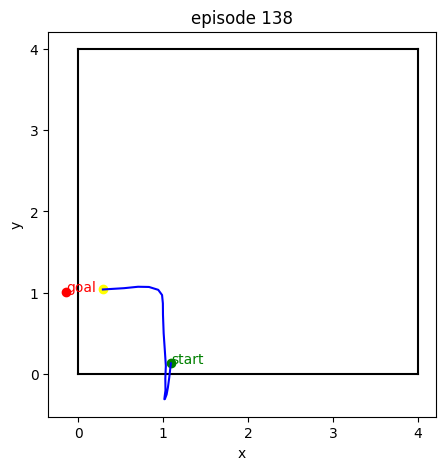

episode done at 138


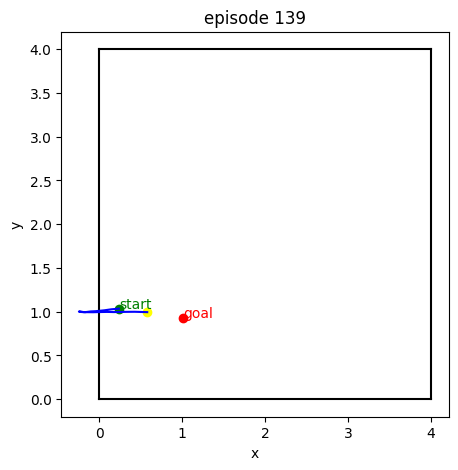

episode done at 139


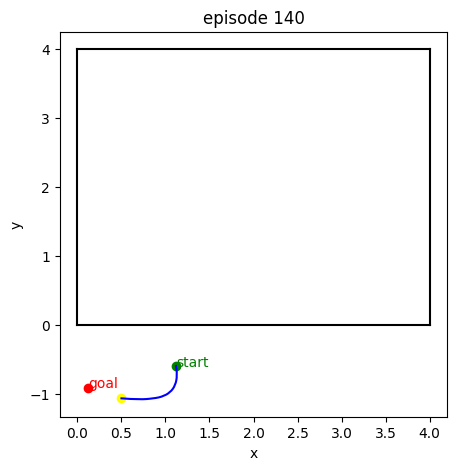

episode done at 140


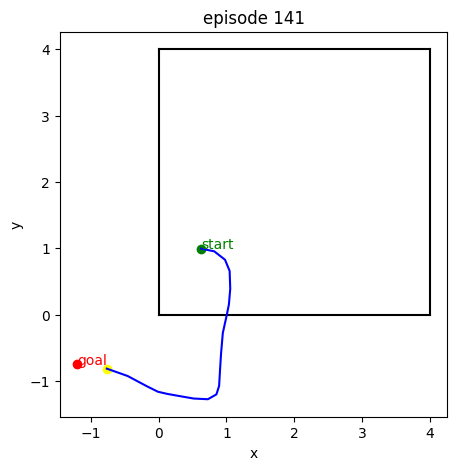

episode done at 141


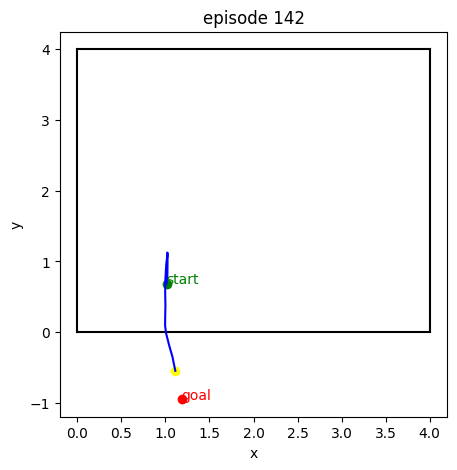

episode done at 142


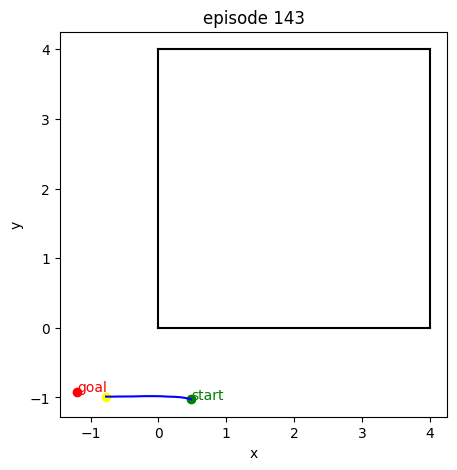

episode done at 143


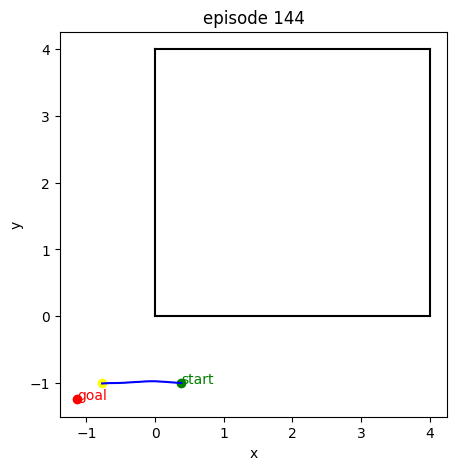

episode done at 144


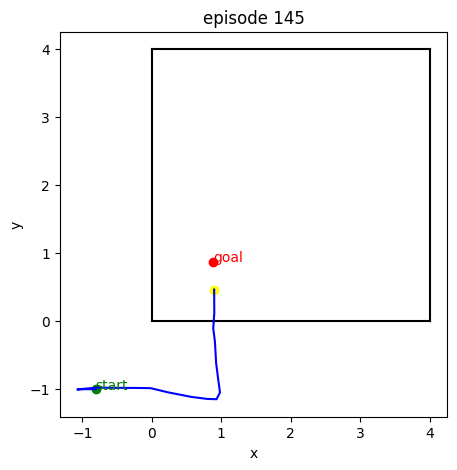

episode done at 145


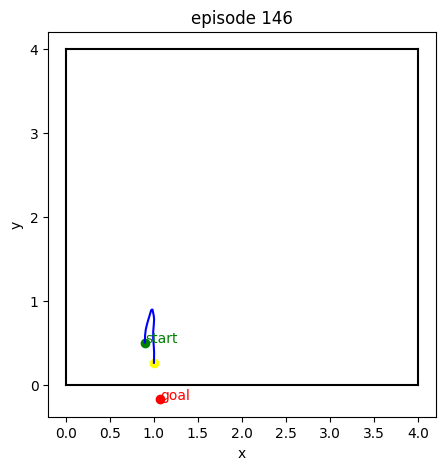

episode done at 146


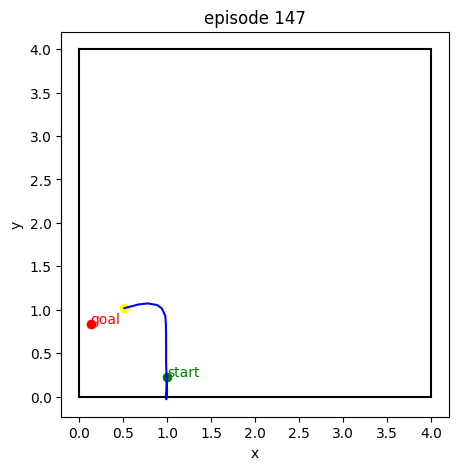

episode done at 147


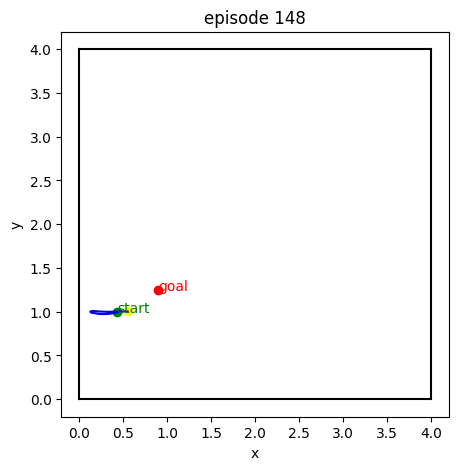

episode done at 148


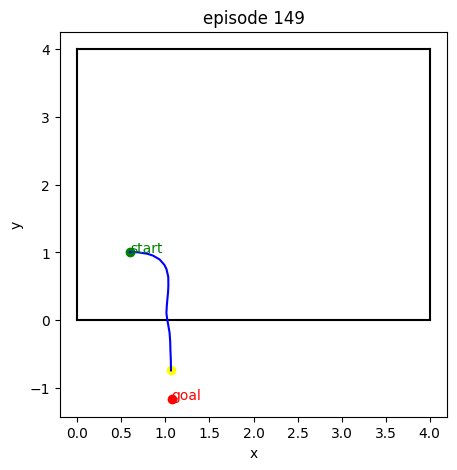

episode done at 149


KeyboardInterrupt: 

<Figure size 500x500 with 0 Axes>

In [47]:
# plot map with matplotlib
import matplotlib.pyplot as plt

map_size = ((-2,2),(-2,2)) # x, y


def init_figure() :
    # draw outline 
    plt.figure(figsize=(5,5))
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][0], map_size[1][0]], color='black')
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][1], map_size[1][1]], color='black')
    plt.plot([map_size[0][0], map_size[0][0]], [map_size[1][0], map_size[1][1]], color='black')
    plt.plot([map_size[0][1], map_size[0][1]], [map_size[1][0], map_size[1][1]], color='black')
    # set figure size


def plot_trajectory(trajectory, color='blue'):
    # plot trajectory
    plt.plot(trajectory[:,0], trajectory[:,1], color=color)

start_i = 0
n_frames = len(data)
episode_frames = []
episode_agent_states = []
episode_goals = []
episode_start = start_i
episode_done = False

print(len(data))
for i in range (start_i, start_i + n_frames) :
    achieved_goal = data[i]['observations'][:,:2]
    desired_goals = data[i]['observations'][:,-2:]

    # draw trajectory
    init_figure()
    plot_trajectory(np.array(achieved_goal))
    # draw goals
    plt.scatter(desired_goals[-1][0], desired_goals[-1][1], color='red')
    # draw start
    plt.scatter(achieved_goal[0][0], achieved_goal[0][1], color='green')
    # draw end
    plt.scatter(achieved_goal[-1][0], achieved_goal[-1][1], color='yellow')
    # add labels that show what meaning of green, yellow, red
    plt.text(achieved_goal[0][0], achieved_goal[0][1], 'start', color='green')
    #plt.text(episode_agent_states[-1][0], episode_agent_states[-1][1], 'end', color='yellow')
    plt.text(desired_goals[-1][0], desired_goals[-1][1], 'goal', color='red')
    
    plt.title(f'episode {i}')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()
    episode_agent_states = []
    episode_goals = []
    episode_done = False
    print('episode done at', i)


In [45]:
data[0]['observations'].shape

TypeError: list indices must be integers or slices, not str